# Data-driven predictions of the likelihood that annual global mean temperature will exceed 1.5˚C, 2.0˚C in the next decade
##### authors: Jamin K. Rader, Elizabeth A. Barnes and Noah S. Diffenbaugh
##### date: April 12, 2024

This is the main script for creating the figures in the paper.

First follow the README to train the neural networks used in the main text. Run these cells in order to produce all the figures.

In [1]:
import sys, imp, os, time

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import keras
import shash_tfp

import experiment_settings
import file_methods, plots, custom_metrics, network, data_processing, base_directories
from tune import get_best_models, get_model_losses

import matplotlib as mpl
import seaborn as sb
import cartopy.crs as ccrs
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 100
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)

RETRAIN_MODELS = False
OVERWRITE_MODEL = True

dir_settings = base_directories.get_directories()

MODEL_DIRECTORY = dir_settings['models']       
PREDICTIONS_DIRECTORY = dir_settings['predictions']   
DATA_DIRECTORY = dir_settings['data']   
DIAGNOSTICS_DIRECTORY = dir_settings['diagnostics']   
FIGURE_DIRECTORY = dir_settings['figure']   

/var/folders/n0/lbfykggx3_qfdp76fhhbtk_80000gn/T/ipykernel_29343/2590295067.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import sys, imp, os, time


2.7.0
0.15.0


In [2]:
### Predictions for the delta model

def get_delta_input(baseline_model, x_test):
    map_input = x_test[..., 1:]
    baseline_input = x_test[..., 0]
    baseline_input = np.stack(baseline_model(x_test[..., 0]), axis=-1).squeeze()

    return (map_input, baseline_input,)

def delta_predict(delta_model, baseline_model, x_test):
    delta_input = get_delta_input(baseline_model, x_test)
    return delta_model.predict(delta_input)

### Calculating the probability of exceedance
def calc_probability_exceedance(full_model_list, obsmax=1.41):
    # Calculate 2021 obs for each model
    probs15 = []
    probs17 = []
    probs20 = []
    probsmax= []
    for full_model in full_model_list:
        for probs_list, thresh in zip([probs15, probs17, probs20, probsmax], 
                                    [1.5, 1.7, 2.0, obsmax]):
            pred_obs = full_model.predict(x_obs)
            probs_list.append(pdf(*pred_obs[-1, :].tolist(), truth = thresh, color='#4a86e8', printodds=False, plot_dist=False, fill=True))
    return probs15, probs17, probs20, probsmax

def calc_mae(x, y):

    top_pred_idx = 0

    baseline_mae_list = []
    full_mae_list = []

    for full_model, baseline_model in zip(full_model_list, baseline_model_list):
        test_shash = full_model.predict(x)
        predict_test = test_shash[:,top_pred_idx].flatten()
        mae_1_2 = np.mean(np.abs(predict_test[np.logical_and(y>1, y<2)]-y[np.logical_and(y>1, y<2)]))

        bl_test_shash = baseline_model.predict(x[..., 0])
        bl_predict_test = bl_test_shash[top_pred_idx].flatten()
        bl_mae_1_2 = np.mean(np.abs(bl_predict_test[np.logical_and(y>1, y<2)]-y[np.logical_and(y>1, y<2)]))

        baseline_mae_list.append(bl_mae_1_2)
        full_mae_list.append(mae_1_2)

    baseline_mae_arr = np.array(baseline_mae_list)
    full_mae_arr = np.array(full_mae_list)

    return baseline_mae_arr, full_mae_arr

def calc_obs_mae(x, y, yrs, obs_start = 0, obs_end = 9999):

    top_pred_idx = 0

    boolyear = np.logical_and(yrs>= obs_start, yrs<obs_end)

    baseline_mae_list = []
    full_mae_list = []

    for full_model, baseline_model in zip(full_model_list, baseline_model_list):
        test_shash = full_model.predict(x[boolyear])
        predict_test = test_shash[:,top_pred_idx].flatten()
        mae = np.mean(np.abs(predict_test-y[boolyear]))

        bl_test_shash = baseline_model.predict(x[boolyear, ..., 0])
        bl_predict_test = bl_test_shash[top_pred_idx].flatten()
        bl_mae = np.mean(np.abs(bl_predict_test-y[boolyear]))

        baseline_mae_list.append(bl_mae)
        full_mae_list.append(mae)

    baseline_mae_arr = np.array(baseline_mae_list)
    full_mae_arr = np.array(full_mae_list)

    return baseline_mae_arr, full_mae_arr

def calc_loss(x, y):

    baseline_loss_list = []
    full_loss_list = []

    for full_model, baseline_model in zip(full_model_list, baseline_model_list):
        test_shash = full_model.predict(x)
        predict_test = test_shash
        loss = network.RegressLossExpSigma(y[..., None], predict_test)

        bl_test_shash = baseline_model.predict(x[..., 0])
        bl_predict_test = np.stack(bl_test_shash, axis=-1).squeeze()
        bl_loss = network.RegressLossExpSigma(y[..., None], bl_predict_test)

        baseline_loss_list.append(bl_loss)
        full_loss_list.append(loss)

    baseline_loss_arr = np.array(baseline_loss_list)
    full_loss_arr = np.array(full_loss_list)

    return baseline_loss_arr, full_loss_arr


def calc_obs_loss(x, y, yrs, obs_start = 0, obs_end = 9999):

    boolyear = np.logical_and(yrs>= obs_start, yrs<obs_end)

    baseline_loss_list = []
    full_loss_list = []

    for full_model, baseline_model in zip(full_model_list, baseline_model_list):
        test_shash = full_model.predict(x[boolyear])
        predict_test = test_shash
        loss = network.RegressLossExpSigma(y[boolyear][..., None], predict_test)

        bl_test_shash = baseline_model.predict(x[boolyear, ..., 0])
        bl_predict_test = np.stack(bl_test_shash, axis=-1).squeeze()
        bl_loss = network.RegressLossExpSigma(y[boolyear][..., None], bl_predict_test)

        baseline_loss_list.append(bl_loss)
        full_loss_list.append(loss)

    baseline_loss_arr = np.array(baseline_loss_list)
    full_loss_arr = np.array(full_loss_list)

    return baseline_loss_arr, full_loss_arr

def build_pdf(mean, std, x):
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y

def aoc(x, y, threshold, color='plum', plot=True):
    if plot:
        plt.plot(x, total_pdf, '-', color = '#4a86e8', linewidth = 3)
        plt.axvline(threshold, color = 'red', linestyle = '--')
        fillwhere = x>threshold
        plt.fill_between(x, 0, y, where=fillwhere, color=color, alpha=.4, zorder=0)

    binwidth = x[1] - x[0]
    area_greater = np.sum((y*binwidth)[x>= threshold])
    area_lesser = np.sum((y*binwidth)[x < threshold])

    #print('Area Under Curve, >= threshold:' + str(area_greater))
    #print('Area Under Curve, < threshold:' + str(area_lesser))
    return area_greater

def calc_y_obs(global_mean_map = None, global_mean_vals = None):
    assert global_mean_map is not None or global_mean_vals is not None, "One of the inputs to calc_y_obs must not be None"
    if global_mean_map != None:
        weights = np.cos(np.deg2rad(da_obs.lat))
        weights.name = "weights"
        da_obs_weighted = (global_mean_map).weighted(weights)
        global_mean_vals = da_obs_weighted.mean(["lat", "lon"])

    BEST_2023_mean = 1.54
    ann_mean_v_anom_diff = BEST_2023_mean - global_mean_vals[2023-end_year-1]
    ann_mean_anom_obs = global_mean_vals + ann_mean_v_anom_diff
    roll = settings['len_window']
    max_T_anom_obs = ann_mean_anom_obs.rolling(min_periods=roll, center=False, time=roll).max().shift(shifts={"time":-roll})
    return max_T_anom_obs, ann_mean_anom_obs

def get_gradients(model, inputs, baseline_inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model([inputs, baseline_inputs], training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            #preds = preds[:, top_pred_idx]
            preds = preds[top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(model, inputs, baseline_inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    input_size = np.shape(inputs)[1:]
    if baseline is None:
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = np.full(input_size, baseline).astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(model, x_data, baseline_inputs, top_pred_idx=top_pred_idx)
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def calc_xai(x, musigmaidx):
    inputs1, inputs2 = get_delta_input(baseline_model, x)
    xai = get_integrated_gradients(delta_model, inputs1, inputs2, baseline=musigmaidx, num_steps=50, top_pred_idx=musigmaidx)  
    return  xai

def pdf(mean, std, truth = None, color = 'red', sumside='higher', plot_dist=True, printodds=False, fill=False):
    zscore_width = 5.
    x = np.arange(mean-zscore_width*std, mean + zscore_width*std+.00001, 0.001)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    if plot_dist:
        plt.plot(x, y, color=color, linewidth=4, label='Prediction')
        plt.ylim([0, None])
        plt.xlim(x.min(), x.max())
        if truth is not None:
            plt.axvline(truth, color = '#cc4125', linestyle = '--', linewidth=3, label='Threshold')
            plt.legend()
    bin_size = (np.max(x) - np.min(x))/len(x)
    undercurve = np.sum(y * bin_size)
    leftoff = (1-undercurve)/2
    if sumside == 'higher':
        odds_are = np.sum(y[x > truth] * bin_size) + leftoff
        if fill and plot_dist:
            fillwhere = x>truth
            plt.fill_between(x, 0, y, where=fillwhere, color=color, alpha=.4, zorder=0)
    elif sumside == 'lower':
        odds_are = np.sum(y[x < truth] * bin_size) + leftoff
        if fill and plot_dist:
            fillwhere = x<truth
            plt.fill_between(x, 0, y, where=fillwhere, color=color, alpha=.4, zorder=0)
    if printodds:
        textodds = "{:.2f}".format(odds_are*100) + '%'
        print('Chance ' + sumside + ' than ' "{:.1f}".format(truth) + "˚C: " + textodds)
        if plot_dist:
            try:
                plt.text(np.average(x[fillwhere], weights=y[fillwhere]**2)-4*bin_size, np.mean(y), textodds, fontweight='demi', color=color)
            except:
                plt.text(np.mean(x), np.mean(y), textodds, fontweight='demi', color=color)

    return odds_are

def plot_map(data, vmin=None, vmax=None, cmap=None, coastcolor='k', figsize=(8,4), titles=None):
    if type(data) is not list:
        data = [data]

    fig = plt.figure(figsize=figsize)
    tot_axs = len(data)

    for idx in range(tot_axs):
        ax = plt.subplot(1, tot_axs, idx + 1, projection=ccrs.PlateCarree())
        pcm = ax.pcolormesh(lon, lat, data[idx], cmap=cmap, vmin=vmin, vmax=vmax,)
        plt.colorbar(pcm, ax=ax,fraction=0.032, pad=0.025, extend='both')
        ax.coastlines(color=coastcolor, )
        if titles is not None:
            ax.set_title(titles[idx])
    return fig

# Figures 1, 2, 3, 4, S1, S9

saved_models/chosen1/2024-02-01_1702/chosen1_seed3770_metadata.json
saved_models/chosen1/2024-02-01_1702/chosen1_seed3770_model


observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
Initial Val Loss chosen1 tf.Tensor(-0.49457702, shape=(), dtype=float32) 0.11602037864849986
41/41 [==============================] - 0s 2ms/step - loss: 0.0718 - RegressLossExpSigma: -0.8978 - custom_mae_1: 0.0769
Final Val Loss chosen1 [0.07177732139825821, -0.8978384733200073, 0.07692507654428482]
Window: 1 Thresh: 1.5 Mean: 1.547 Stdev: 0.089
Window: 1 Thresh: 1.5 Initial Odds: 26.03619743484003
Window: 1 Thresh: 1.7 Initial Odds: 2.7005412088188416
Window: 1 Thresh: 2.0 Initial Odds: 0.005793398347361343
Window: 1 Thresh: 1.5 Final Odds: 70.08226995784253
Window: 1 Thresh: 1.7 Final Odds: 4.1850325367107475
Window: 1 Thresh: 2.0 Final Odds: 0.0
chosen1 Initial MAE (1980-present) 0.08798758726730038
chosen1 Final MAE (1980-present) 0.06351782356456462
chosen1 Initial Loss (1980-present) tf.Tensor(-0.6924186, shape=(), dtype=float32)
chosen1 Final Loss (1980-present) tf.Tensor(-1.0820527, shape=(), dtype=float32

/var/folders/n0/lbfykggx3_qfdp76fhhbtk_80000gn/T/ipykernel_29343/1786550912.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


41/41 [==============================] - 0s 2ms/step - loss: 260.6982 - RegressLossExpSigma: -0.4782 - custom_mae_5: 0.1196
Final Val Loss chosen10 [260.6982116699219, -0.47815006971359253, 0.1195758506655693]
Window: 10 Thresh: 1.5 Mean: 1.829 Stdev: 0.145
Window: 10 Thresh: 1.5 Initial Odds: 98.60935932120907
Window: 10 Thresh: 1.7 Initial Odds: 79.45378224068267
Window: 10 Thresh: 2.0 Initial Odds: 10.671003704927157
Window: 10 Thresh: 1.5 Final Odds: 98.81485142251618
Window: 10 Thresh: 1.7 Final Odds: 81.17227373098648
Window: 10 Thresh: 2.0 Final Odds: 11.855893415643907
chosen10 Initial MAE (1980-present) 0.060114391288455075
chosen10 Final MAE (1980-present) 0.06758730322386505
chosen10 Initial Loss (1980-present) tf.Tensor(-0.81455374, shape=(), dtype=float32)
chosen10 Final Loss (1980-present) tf.Tensor(-0.7984033, shape=(), dtype=float32)
chosen10 Initial Pearson r (1980-present) 0.9540514596096998
chosen10 Final Pearson r (1980-present) 0.9523379347083183


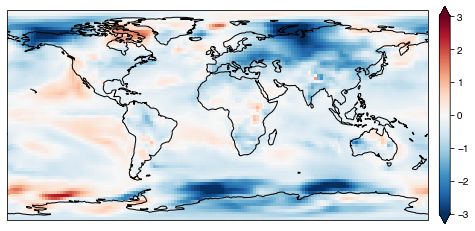

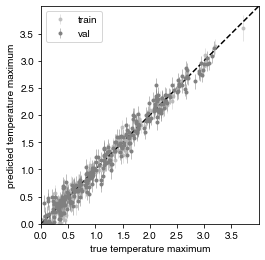

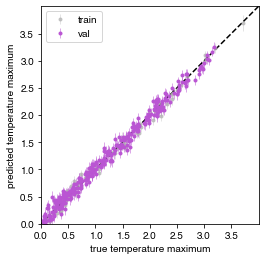

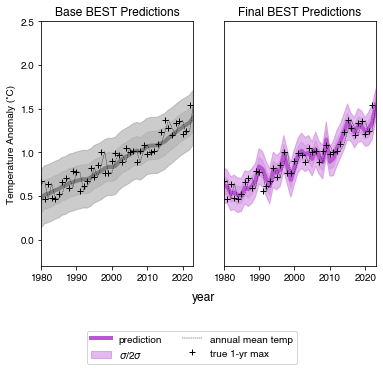

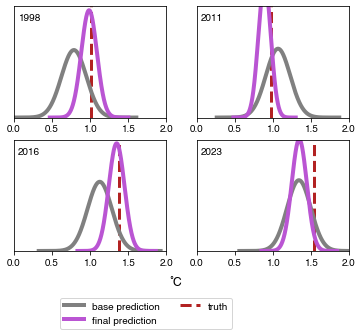

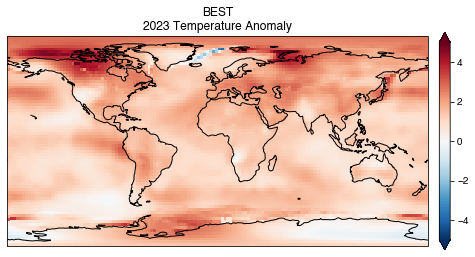

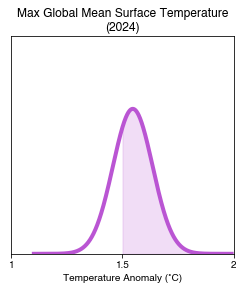

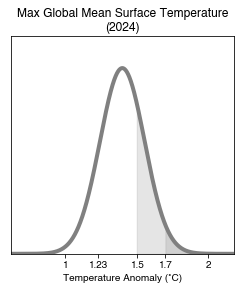

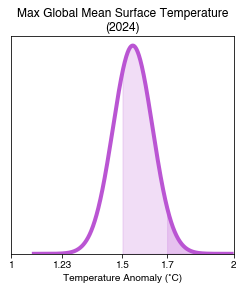

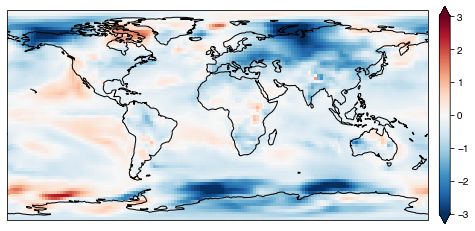

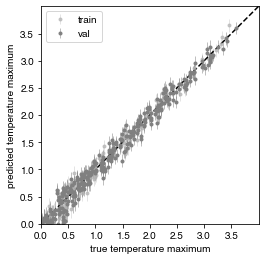

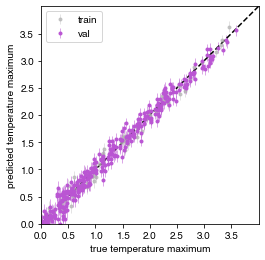

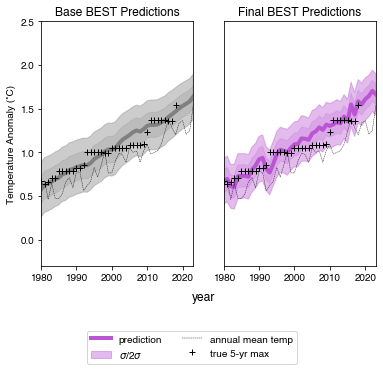

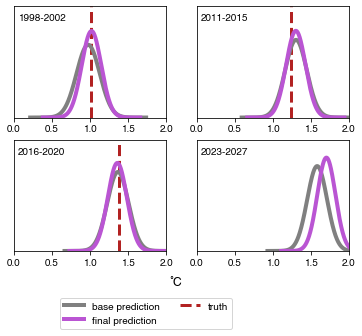

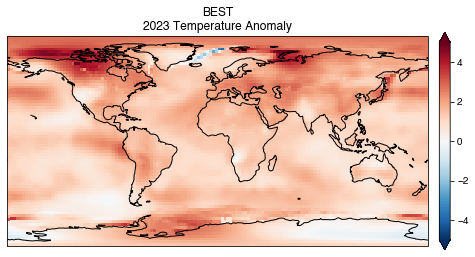

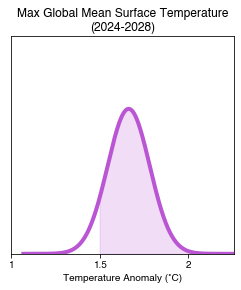

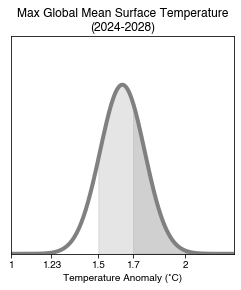

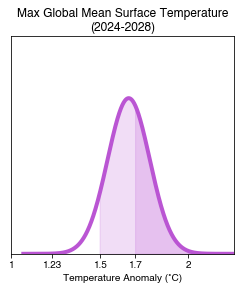

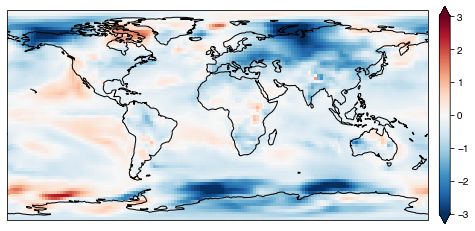

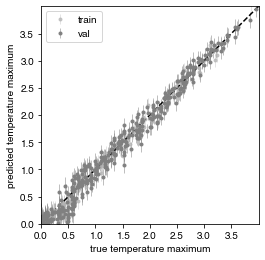

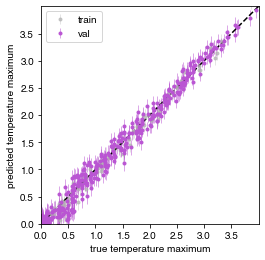

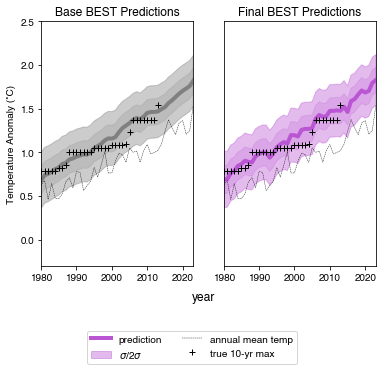

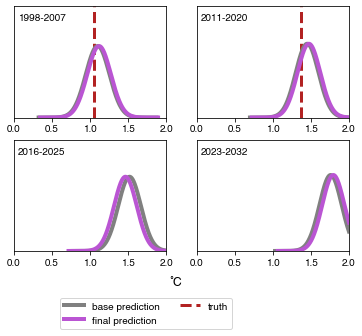

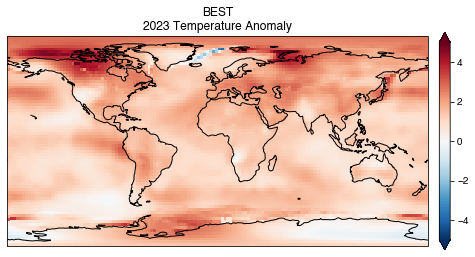

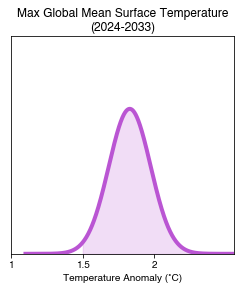

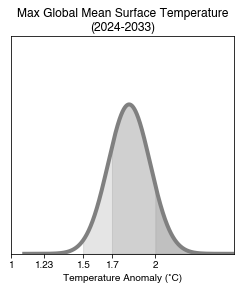

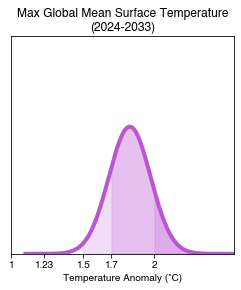

In [3]:
EXP_NAMES = ["chosen1", "chosen5", "chosen10"]
OBS_DATA = 'BEST'

for EXP_NAME in EXP_NAMES:
    settings = experiment_settings.get_settings(EXP_NAME)
    settings["obsdata"] = OBS_DATA
    WINDOW_LEN = str(settings['len_window'])

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'

    full_model_list = []
    baseline_model_list = []
    delta_model_list = []
    model_settings_list = []

    for name in sorted(os.listdir(latest_exp_directory)):
        if os.path.isdir(latest_exp_directory + name):
            print(latest_exp_directory + name)
            full_model_list.append(file_methods.load_tf_model(name, latest_exp_directory))
        elif name.endswith('metadata.json'):
            print(latest_exp_directory + name)
            model_settings_list.append(file_methods.load_settings_model(name, latest_exp_directory))

    for full_model in full_model_list:
        baseline_model_list.append(full_model.get_layer("baseline_model"))
        delta_model_list.append(full_model.get_layer("delta_model"))

    ## choose observations
    METRIC = 'loss'
    da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
    lat = da_obs.lat.values
    lon = da_obs.lon.values

    # params
    end_year = da_obs.time.dt.year.values.max()
    obs_metric_start_year = 1980
    obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)

    # Calculations
    y_obs, ann_mean_obs = calc_y_obs(global_mean_vals = global_mean_obs)
    obs_baseline = ann_mean_obs.values[np.logical_and(obs_yrs<=settings['anomaly_yr_bounds'][1], obs_yrs>=settings['anomaly_yr_bounds'][0])].mean() # To adjust network predictions
    y_obs = y_obs.values

    best_model_index = 0

    full_model, baseline_model, delta_model = full_model_list[best_model_index], \
                                            baseline_model_list[best_model_index], \
                                            delta_model_list[best_model_index]

    # get the data
    (x_train, 
        x_val, 
        x_test, 
        y_train, 
        y_val, 
        y_test, 
        onehot_train, 
        onehot_val, 
        onehot_test, 
        y_yrs_train, 
        y_yrs_val, 
        y_yrs_test, 
        target_years, 
        map_shape,
        settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)
    

    #######################################################################
    #######################################################################
    ### MAKING PLOTS 
    #######################################################################
    #######################################################################

    #################
    ### PLOT SAMPLE INPUT (FINAL NETWORK)
    #################

    example_map = x_train[30,..., 1].reshape(len(lat), len(lon))
    fig = plot_map(example_map, cmap = 'RdBu_r', vmin = -3, vmax = 3,)
    fig.savefig('final_figures/main/sample_GCM_input_map.png', dpi=300)

    #################
    ### PLOT VALIDATION PREDICTIONS (INITIAL NETWORK)
    #################

    lowlim = 0
    hilim = 4

    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)

    xset, yset = x_train, y_train
    initial_predictions = baseline_model.predict(xset[..., 0])
    n_samples = len(yset)

    subindexing = np.arange(0, n_samples, 20)
    plt.errorbar(yset[subindexing], initial_predictions[0].flatten()[subindexing],  
                yerr=initial_predictions[1].flatten()[subindexing], fmt='.', color = '.7', alpha = .7, label='train',
                linewidth=.5)

    xset, yset = x_test, y_test
    initial_predictions = baseline_model.predict(xset[..., 0])
    print('Initial Val Loss', EXP_NAME, network.RegressLossExpSigma(yset[...,None], np.concatenate(initial_predictions, axis=-1)), np.mean(np.abs(yset - initial_predictions[0].squeeze())))
    n_samples = len(yset)

    subindexing = np.arange(0, n_samples, 3)
    plt.errorbar(yset[subindexing], initial_predictions[0].flatten()[subindexing],  
                yerr=initial_predictions[1].flatten()[subindexing], fmt='.', color = 'gray', alpha = 1, label='val',
                linewidth=.5)
    plt.plot([lowlim,hilim], [lowlim,hilim], 'k--')

    plt.ylim(lowlim, hilim)
    plt.xlim(lowlim, hilim)
    plt.yticks(np.arange(lowlim,hilim, .5))
    plt.xticks(np.arange(lowlim,hilim, .5))
    plt.legend(loc=2)
    plt.xlabel('true temperature maximum')
    plt.ylabel('predicted temperature maximum')

    ax.set_aspect('equal', adjustable='box')

    fig.savefig('final_figures/main/initial_validation_predictions_window=' + WINDOW_LEN + '.png', dpi=300)

    #################
    ### PLOT VALIDATION PREDICTIONS (FINAL NETWORK)
    #################
    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)

    xset, yset = x_train, y_train
    final_predictions = full_model.predict(xset)
    n_samples = len(yset)

    subindexing = np.arange(0, n_samples, 20)
    plt.errorbar(yset[subindexing],final_predictions[:,0].flatten()[subindexing],  
                yerr=final_predictions[:,1].flatten()[subindexing], fmt='.', color = '.7', alpha = .7, label='train',
                linewidth=.5)

    xset, yset = x_test, y_test
    final_predictions = full_model.predict(xset)
    full_model.compile(metrics=[network.RegressLossExpSigma, custom_metrics.CustomMAE()])
    print('Final Val Loss', EXP_NAME, full_model.evaluate(xset, yset))
    n_samples = len(yset)

    subindexing = np.arange(0, n_samples, 3)
    plt.errorbar(yset[subindexing],final_predictions[:,0].flatten()[subindexing],  
                yerr=final_predictions[:,1].flatten()[subindexing], fmt='.', color = 'mediumorchid', alpha = 1, label='val',
                linewidth=.5)
    plt.plot([lowlim,hilim], [lowlim,hilim], 'k--')

    plt.ylim(lowlim, hilim)
    plt.xlim(lowlim, hilim)
    plt.yticks(np.arange(lowlim,hilim, .5))
    plt.xticks(np.arange(lowlim,hilim, .5))
    plt.xlabel('true temperature maximum')
    plt.ylabel('predicted temperature maximum')
    plt.legend(loc=2)

    ax.set_aspect('equal', adjustable='box')

    fig.savefig('final_figures/main/final_validation_predictions_window=' + WINDOW_LEN + '.png', dpi=300)

    #################
    ### PLOT OBS PREDICTIONS 1980-present
    #################

    fig = plt.figure(figsize=(6,4.5))
    yrs = np.arange(end_year - x_obs.shape[0] + 1, end_year+1)

    musig = np.concatenate(baseline_model.predict(x_obs[..., 0]), axis=-1)
    mu = musig[:,0]
    sig = musig[:,1]
    pred_obs = np.stack([mu + obs_baseline, sig], axis=-1)

    plt.subplot(1,2,1)
    plt.plot(yrs, pred_obs[:, 0], linewidth=4, label='prediction', color='gray')
    plt.fill_between(yrs, pred_obs[:, 0] + 2*pred_obs[:, 1], pred_obs[:, 0] - 2*pred_obs[:, 1], label='$\sigma$/2$\sigma$', alpha=.4, color='gray')
    plt.fill_between(yrs, pred_obs[:, 0] + 1*pred_obs[:, 1], pred_obs[:, 0] - 1*pred_obs[:, 1], alpha=.2, color='gray')
    plt.plot(yrs, ann_mean_obs, '--',linewidth=.4, color='black', label = 'annual mean temp')
    plt.plot(yrs, y_obs, '+', label='truth', color='k')
    #plt.legend(loc=2)
    plt.title('Base '+ settings['obsdata'] + ' Predictions')
    plt.xlim(1980, 2023)
    plt.ylim(-.3, 2.5)
    plt.ylabel('Temperature Anomaly (˚C)')

    musig = full_model.predict(x_obs)    
    mu = musig[:,0]
    sig = musig[:,1]
    pred_obs = np.stack([mu + obs_baseline, sig], axis=-1)

    plt.subplot(1,2,2)
    plt.plot(yrs, pred_obs[:, 0], linewidth=4, label='prediction', color='mediumorchid')
    plt.fill_between(yrs, pred_obs[:, 0] + 2*pred_obs[:, 1], pred_obs[:, 0] - 2*pred_obs[:, 1], alpha=.4, label='$\sigma$/2$\sigma$', color='mediumorchid')
    plt.fill_between(yrs, pred_obs[:, 0] + 1*pred_obs[:, 1], pred_obs[:, 0] - 1*pred_obs[:, 1], alpha=.2, color='mediumorchid')
    plt.plot(yrs, ann_mean_obs, '--',linewidth=.4, color='black', label = 'annual mean temp')
    plt.plot(yrs, y_obs, '+', label='true ' + WINDOW_LEN + '-yr max', color='k')
    plt.legend(loc=(-.9,-.4), ncol=2)
    plt.title('Final '+ settings['obsdata'] + ' Predictions')
    plt.xlim(1980, 2023)
    plt.ylim(-.3, 2.5)
    plt.yticks([]);
    fig.supxlabel('year', size=12)

    assert settings["obsdata"] == OBS_DATA

    fig.savefig('final_figures/main/all_' + settings['obsdata'] + '_predictions_window=' + WINDOW_LEN + '.png', dpi=300, bbox_inches='tight')

    #################
    ### PLOT SINGLE OBS PREDICTIONS (e.g. 1997, 2010, 2015, 2022)
    #################
    def justpdf(mean, std, truth = None, color = 'black', label='prediction'):
        zscore_width = 5.
        x = np.arange(mean-zscore_width*std, mean + zscore_width*std+.00001, 0.001)
        y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
        plt.plot(x, y, color=color, linewidth=4, label=label)
        plt.ylim([0, None])
        plt.xlim(x.min(), x.max())
        if truth is not None:
            plt.axvline(truth, color = 'firebrick', linestyle = '--', alpha = 1, linewidth=3, label='truth', zorder=0)
        return x

    fig = plt.figure(figsize=(6,4.5))
    for iyear, year in enumerate([1997, 2010, 2015, 2022]):
        ax = plt.subplot(2,2,iyear+1)
        thisobs = x_obs[obs_yrs == year]
        pred_obs = np.concatenate(baseline_model.predict(thisobs[..., 0]), axis=-1).squeeze()
        mu, sigma = pred_obs 
        mu = mu + obs_baseline
        x = justpdf(mu, sigma, color='gray', label='base prediction')
        pred_obs = full_model.predict(thisobs).squeeze()
        mu, sigma = pred_obs 
        mu = mu + obs_baseline
        x = justpdf(mu, sigma, color='mediumorchid', truth = y_obs[obs_yrs == year].squeeze(), label = 'final prediction')
        plt.ylim(0,4)
        plt.xlim(0,2)
        plt.yticks([])
        if settings['len_window'] > 1:
            plt.text(.05, 3.5, str(year+1) + '-' + str(year+settings['len_window']))
        else:
            plt.text(.05, 3.5, str(year+1))
    plt.xlabel('')
    fig.supxlabel('˚C', size=12)

    plt.legend(loc=(-.9,-.7), ncol=2)
    fig.savefig('final_figures/main/single_' + settings['obsdata'] + '_predictions_window=' + WINDOW_LEN + '.png', dpi=300, bbox_inches='tight')

    #################
    ### PLOT 2023 MAP
    #################

    example_map = (x_obs[-1,..., 1] + x_obs[-1,..., 0]).reshape(len(lat), len(lon))
    fig = plot_map(example_map, cmap = 'RdBu_r', vmin = -5, vmax = 5,)
    plt.title(settings["obsdata"] + '\n' + str(end_year) + ' Temperature Anomaly')
    fig.savefig('final_figures/main/input_map_' + settings['obsdata'] + '_2023.png', dpi=300, bbox_inches='tight')

    #################
    ### PLOT FINAL NETWORK PRED 2023 + ONLY 1.5 LIKELIHOOD (no print)
    #################

    fig = plt.figure(figsize = (4,4))

    mean, std = np.array(full_model.predict(x_obs[-1:,...,])).squeeze()
    mean = mean + obs_baseline

    color = 'mediumorchid'

    zscore_width = 5.
    x = np.arange(mean-zscore_width*std, mean + zscore_width*std+.00001, 0.001)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    plt.plot(x, y, color=color, linewidth=4)
    plt.ylim([0, int(np.max(y) * 1.5)])
    plt.xlim(x.min(), x.max())
    plt.yticks([])
    ticks = [1, 1.5, 2]
    plt.xticks(ticks, [str(i) for i in ticks])
    if settings["len_window"] == 1:
        plt.title('Max Global Mean Surface Temperature\n(' + str(end_year + 1) + ')')
    else:
        final_pred_year = str(end_year+settings["len_window"])
        plt.title('Max Global Mean Surface Temperature\n(' + str(end_year + 1) + '-' + final_pred_year + ')')
    plt.xlabel('Temperature Anomaly (˚C)')

    for thresh in [1.5]:
        fill_area = x[x >= thresh]
        plt.fill_between(fill_area, 0, y[x>thresh], color='mediumorchid', alpha=.2)
        leftover = (1 - np.sum(y*(x[1]-x[0])))//2
        odds = np.sum(y[x >= thresh]*(x[1]-x[0])) + leftover
    print('Window: ' + WINDOW_LEN + ' Thresh: ' + str(thresh) + ' Mean: ' + str(mean.round(3))+ ' Stdev: ' + str(std.round(3)))
    plt.ylim(0,1.5* np.max(y))
    fig.savefig('final_figures/main/2023finalprediction_15only_window=' + WINDOW_LEN + '.png', dpi=300, bbox_inches='tight')

    #################
    ### PLOT INITIAL NETWORK PRED 2023 + PRINT LIKELIHOODS
    #################

    fig = plt.figure(figsize = (4,4))

    mean, std = np.array(baseline_model.predict(x_obs[-1:,..., 0])).squeeze()
    mean = mean + obs_baseline

    color = 'gray'

    zscore_width = 5.
    x = np.arange(mean-zscore_width*std, mean + zscore_width*std+.00001, 0.001)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    plt.plot(x, y, color=color, linewidth=4)
    plt.ylim([0, int(np.max(y) * 1.5)])
    plt.xlim(x.min(), x.max())
    plt.yticks([])
    ticks = [1, 1.23, 1.5, 1.7, 2]
    plt.xticks(ticks, [str(i) for i in ticks])
    if settings["len_window"] == 1:
        plt.title('Max Global Mean Surface Temperature\n(' + str(end_year + 1) + ')')
    else:
        final_pred_year = str(end_year+settings["len_window"])
        plt.title('Max Global Mean Surface Temperature\n(' + str(end_year + 1) + '-' + final_pred_year + ')')
    plt.xlabel('Temperature Anomaly (˚C)')

    for thresh in [1.5, 1.7, 2.0]:
        fill_area = x[x >= thresh]
        plt.fill_between(fill_area, 0, y[x>thresh], color='gray', alpha=.2)
        leftover = (1 - np.sum(y*(x[1]-x[0])))//2
        odds = np.sum(y[x >= thresh]*(x[1]-x[0])) + leftover
        print('Window: ' + WINDOW_LEN + ' Thresh: ' + str(thresh) + ' Initial Odds: ' +str(odds*100))

    fig.savefig('final_figures/main/2023initialprediction_window=' + WINDOW_LEN + '.png', dpi=300, bbox_inches='tight')

    #################
    ### PLOT FINAL NETWORK PRED 2023 + PRINT LIKELIHOODS
    #################

    fig = plt.figure(figsize = (4,4))

    mean, std = full_model.predict(x_obs[-1:,...]).squeeze()
    mean = mean + obs_baseline

    color = 'mediumorchid'

    zscore_width = 5.
    x = np.arange(mean-zscore_width*std, mean + zscore_width*std+.00001, 0.001)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    plt.plot(x, y, color=color, linewidth=4)
    plt.ylim([0, 4.7])
    plt.xlim(x.min(), x.max())
    plt.yticks([])
    ticks = [1, 1.23, 1.5, 1.7, 2]
    plt.xticks(ticks, [str(i) for i in ticks])
    if settings["len_window"] == 1:
        plt.title('Max Global Mean Surface Temperature\n(' + str(end_year + 1) + ')')
    else:
        final_pred_year = str(end_year+settings["len_window"])
        plt.title('Max Global Mean Surface Temperature\n(' + str(end_year + 1) + '-' + final_pred_year + ')')
    plt.xlabel('Temperature Anomaly (˚C)')

    for thresh in [1.5, 1.7, 2.0]:
        fill_area = x[x >= thresh]
        plt.fill_between(fill_area, 0, y[x>thresh], color='mediumorchid', alpha=.2)
        leftover = (1 - np.sum(y*(x[1]-x[0])))//2
        odds = np.sum(y[x >= thresh]*(x[1]-x[0])) + leftover
        print('Window: ' + WINDOW_LEN + ' Thresh: ' + str(thresh) + ' Final Odds: ' +str(odds*100))

    fig.savefig('final_figures/main/2023finalprediction_window=' + WINDOW_LEN + '.png', dpi=300, bbox_inches='tight')


    #################
    ### PRINT OBS LOSSES
    #################
    years_to_assess_metrics = np.logical_and(obs_yrs >= 1980, obs_yrs <= obs_yrs[-1]-settings["len_window"])
    metric_y_obs = y_obs[years_to_assess_metrics]
    full_obs_predict = full_model.predict(x_obs[years_to_assess_metrics])
    init_obs_predict = baseline_model.predict(x_obs[years_to_assess_metrics, ..., 0])
    init_obs_predict = np.stack(init_obs_predict, axis=1).squeeze()
    init_obs_predict[:, 0] = init_obs_predict[:, 0] + obs_baseline # adjust mu by baseline
    full_obs_predict[:, 0] = full_obs_predict[:, 0] + obs_baseline # adjust my by baseline
    # Calculate the MAE
    init_mae = np.mean(np.abs(init_obs_predict[:, 0] - metric_y_obs))
    full_mae = np.mean(np.abs(full_obs_predict[:, 0] - metric_y_obs))
    # Calculate the Loss
    init_loss = network.RegressLossExpSigma(metric_y_obs[..., None], init_obs_predict)
    full_loss = network.RegressLossExpSigma(metric_y_obs[..., None], full_obs_predict)
    # Calculate the Pearson's r
    init_corr = np.corrcoef(metric_y_obs, init_obs_predict[:, 0])[0,1]
    full_corr = np.corrcoef(metric_y_obs, full_obs_predict[:, 0])[0,1]
    print(EXP_NAME, "Initial MAE (1980-present)", init_mae)
    print(EXP_NAME, "Final MAE (1980-present)", full_mae)
    print(EXP_NAME, "Initial Loss (1980-present)", init_loss)
    print(EXP_NAME, "Final Loss (1980-present)", full_loss)
    print(EXP_NAME, "Initial Pearson r (1980-present)", init_corr)
    print(EXP_NAME, "Final Pearson r (1980-present)", full_corr)

In [5]:
# Calculate likelihoods for difference 1850-1900 baseline temperature estimates
agencies = ['BEST', 'ECMWF', 'HadCRUT', 'WMO', 'NASA', 'NOAA']
baselines = [1.54, 1.48, 1.46, 1.45, 1.37, 1.34]
thresholds = [1.5, 1.7, 2.0]
EXP_NAMES = ["chosen1", "chosen5", "chosen10"]
OBS_DATA = 'BEST'

def calc_y_obs_baseline(global_mean_map = None, global_mean_vals = None, baseline=1.54):
    assert global_mean_map is not None or global_mean_vals is not None, "One of the inputs to calc_y_obs must not be None"
    if global_mean_map != None:
        weights = np.cos(np.deg2rad(da_obs.lat))
        weights.name = "weights"
        da_obs_weighted = (global_mean_map).weighted(weights)
        global_mean_vals = da_obs_weighted.mean(["lat", "lon"])
    mean_from_baseline_2023 = baseline
    ann_mean_v_anom_diff = mean_from_baseline_2023 - global_mean_vals[2023-end_year-1]
    ann_mean_anom_obs = global_mean_vals + ann_mean_v_anom_diff
    roll = settings['len_window']
    max_T_anom_obs = ann_mean_anom_obs.rolling(min_periods=roll, center=False, time=roll).max().shift(shifts={"time":-roll})
    return max_T_anom_obs, ann_mean_anom_obs

for EXP_NAME in EXP_NAMES:
    settings = experiment_settings.get_settings(EXP_NAME)
    settings["obsdata"] = OBS_DATA
    WINDOW_LEN = str(settings['len_window'])

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'

    full_model_list = []
    baseline_model_list = []
    delta_model_list = []
    model_settings_list = []

    for name in sorted(os.listdir(latest_exp_directory)):
        if os.path.isdir(latest_exp_directory + name):
            print(latest_exp_directory + name)
            full_model_list.append(file_methods.load_tf_model(name, latest_exp_directory))
        elif name.endswith('metadata.json'):
            print(latest_exp_directory + name)
            model_settings_list.append(file_methods.load_settings_model(name, latest_exp_directory))

    for full_model in full_model_list:
        baseline_model_list.append(full_model.get_layer("baseline_model"))
        delta_model_list.append(full_model.get_layer("delta_model"))

    ## choose observations
    METRIC = 'loss'
    da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
    lat = da_obs.lat.values
    lon = da_obs.lon.values

    # params
    end_year = da_obs.time.dt.year.values.max()
    obs_metric_start_year = 1980
    obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)
    best_model_index = 0
    full_model, baseline_model, delta_model = full_model_list[best_model_index], \
                                            baseline_model_list[best_model_index], \
                                            delta_model_list[best_model_index]
    da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
    print('GLOBAL MEAN', global_mean_obs[-1])
    print(EXP_NAME)
    musig = full_model.predict(x_obs[obs_yrs==2023]) 
    for agency, baseline in zip(agencies, baselines):

        y_obs, ann_mean_obs = calc_y_obs_baseline(global_mean_vals = global_mean_obs, baseline=baseline)
        obs_baseline = ann_mean_obs.values[np.logical_and(obs_yrs<=settings['anomaly_yr_bounds'][1], obs_yrs>=settings['anomaly_yr_bounds'][0])].mean() # To adjust network predictions
        y_obs = y_obs.values

        mu = musig[:,0] + obs_baseline
        sig = musig[:,1]

        print(agency, baseline)
        print('1980-2010 versus 1850-1900:', obs_baseline)

        for threshold in thresholds + [baseline]:
            z = (threshold-mu)/sig
            likelihood = np.round(stats.norm.sf(z) * 100, decimals=2)
            print(str(threshold) + ' Likelihood: ' + str(likelihood[0]))
            

        

saved_models/chosen1/2024-02-01_1702/chosen1_seed3770_metadata.json
saved_models/chosen1/2024-02-01_1702/chosen1_seed3770_model
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
GLOBAL MEAN <xarray.DataArray 'tas' ()>
array(1.20370974)
Coordinates:
    time     object 2023-01-01 00:00:00
chosen1
BEST 1.54
1980-2010 versus 1850-1900: 0.7744064601516585
1.5 Likelihood: 70.17
1.7 Likelihood: 4.21
2.0 Likelihood: 0.0
1.54 Likelihood: 53.11
ECMWF 1.48
1980-2010 versus 1850-1900: 0.714406460151658
1.5 Likelihood: 44.13
1.7 Likelihood: 0.81
2.0 Likelihood: 0.0
1.48 Likelihood: 53.11
HadCRUT 1.46
1980-2010 versus 1850-1900: 0.6944064601516581
1.5 Likelihood: 35.45
1.7 Likelihood: 0.43
2.0 Likelihood: 0.0
1.46 Likelihood: 53.11
WMO 1.45
1980-2010 versus 1850-1900: 0.6844064601516583
1.5 Likelihood: 31.34
1.7 Likelihood: 0.3
2.0 Likelihood: 0.0
1.45 Likelihood: 53.11
NASA 1.37
1980-2010 versus 1850-1900

# Figure S3 -- Three Different Observational Datasets

chosen1_seed3770_model
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
observations: filling NaNs with zeros
np.shape(x_obs) = (144, 10368, 2)
[1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893
 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907
 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921
 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023]
observations: filling NaNs with zeros
np.shape(x_obs) = (84, 10368, 2)
[1940 1941 1942 1943 1944 1945

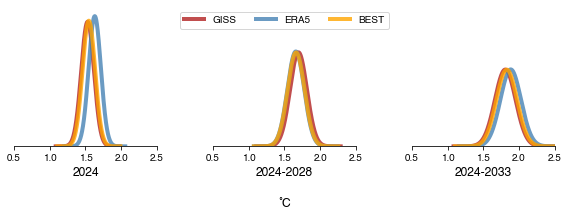

In [11]:
def justpdf(mean, std, truth = None, color = 'black', label='prediction', lw=6):
    zscore_width = 5.
    x = np.arange(mean-zscore_width*std, mean + zscore_width*std+.00001, 0.001)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    plt.plot(x, y, color=color, linewidth=lw, label=label, alpha=.8)
    plt.ylim([0, None])
    plt.xlim(x.min(), x.max())
    if truth is not None:
        plt.axvline(truth, color = 'firebrick', linestyle = '--', alpha = 1, label='truth', zorder=0)
    return x

EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
OBS_DATAS = ['GISS', 'ERA5', 'BEST']
year = 2023

fig = plt.figure(figsize=(8,3))
color = ['firebrick', 'steelblue', 'orange']

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)
    WINDOW_LEN = str(settings['len_window'])

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    print(filename)
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)

    ax = plt.subplot(1,3,iEXP+1)

    settings['obsdata'] = 'BEST'
    da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
    obs_baseline = ann_mean_obs.values[np.logical_and(obs_yrs<=settings['anomaly_yr_bounds'][1], obs_yrs>=settings['anomaly_yr_bounds'][0])].mean() # To adjust network predictions
        

    for iobs, OBS_DATA in enumerate(OBS_DATAS):

        settings["obsdata"] = OBS_DATA
        da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
        end_year = da_obs.time.dt.year.values.max()
        obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)
        y_obs, ann_mean_obs = calc_y_obs(global_mean_vals = global_mean_obs)
        y_obs = y_obs.values
        
        print(obs_yrs)
        if year in obs_yrs:
            thisobs = x_obs[obs_yrs == year]
            pred_obs = full_model.predict(thisobs).squeeze()
            mu, sigma = pred_obs
            mu = mu + obs_baseline
            x = justpdf(mu, sigma, color=color[iobs], label = OBS_DATA, lw=4)
        else:
            plt.plot([], [], color=color[iobs], linewidth=4, label=OBS_DATA, alpha=.8)

    plt.ylim(0,5.0)
    plt.xlim(0.5,2.5)
    plt.yticks([])
    if settings['len_window'] > 1:
        plt.xlabel(str(year+1) + '-' + str(year+settings['len_window']), fontsize=12)
    else:
        plt.xlabel(str(year+1), fontsize=12)
    fig.supxlabel('˚C', size=12)
    sb.despine(left=True, bottom=False)
    if iEXP == 1:
        plt.legend(ncol=3, loc='upper center')
plt.tight_layout()
fig.savefig('final_figures/supp/' + str(year) + '_allobs_predictions.png', dpi=300, bbox_inches='tight')

# Figure S7 -- PIT and PIT-D Metric

In [8]:
import sys, imp, os, time

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import keras

import experiment_settings
import file_methods, plots, custom_metrics, network, data_processing, base_directories, shash_tfp
from tune import get_best_models, get_model_losses

import matplotlib as mpl
import seaborn as sb
import cartopy.crs as ccrs
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 100
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)

RETRAIN_MODELS = False
OVERWRITE_MODEL = True

dir_settings = base_directories.get_directories()

MODEL_DIRECTORY = dir_settings['models']       
PREDICTIONS_DIRECTORY = dir_settings['predictions']   
DATA_DIRECTORY = dir_settings['data']   
DIAGNOSTICS_DIRECTORY = dir_settings['diagnostics']   
FIGURE_DIRECTORY = dir_settings['figure']  

chosen1_seed3770_model
chosen5_seed3770_model
chosen10_seed8319_model


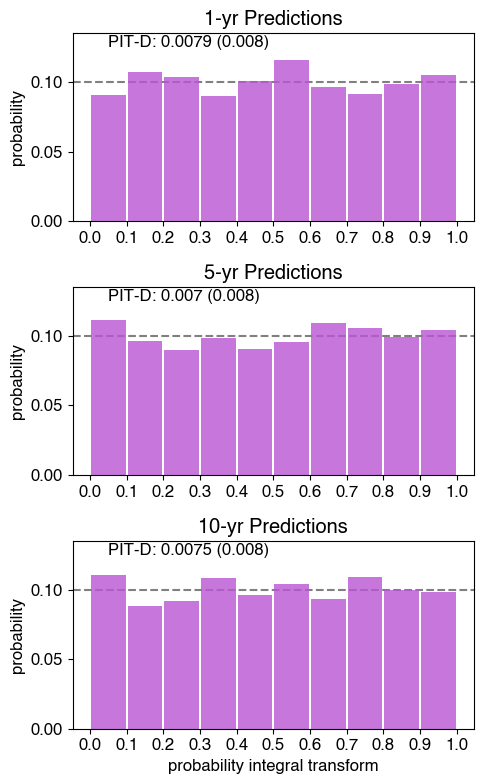

In [9]:
EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
plt.figure(figsize=(5,8))

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    print(filename)
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)

    # get the data
    (x_train, 
        x_val, 
        x_test, 
        y_train, 
        y_val, 
        y_test, 
        onehot_train, 
        onehot_val, 
        onehot_test, 
        y_yrs_train, 
        y_yrs_val, 
        y_yrs_test, 
        target_years, 
        map_shape,
        settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)
    
    # Calculate PITD
    p = full_model.predict(x_val, verbose=0)
    dist = shash_tfp.Shash(p[:, 0], p[:, 1]) #, p[:, 2], p[:, 3])
    F = dist.cdf(onehot_val[:, 0])
    bins = np.linspace(0, 1, 11)
    pit_hist = np.histogram(
        F,
        bins=bins,
        weights=np.ones_like(F) / float(len(F)),
    )
    # PIT metric from Bourdin et al. (2014) and Nipen and Stull (2011).
    B = len(pit_hist[0])
    # PIT metric from Bourdin et al. (2014) and Nipen and Stull (2011).
    # Also, compute expected deviation of PIT for a perfect forecast.
    B = len(pit_hist[0])
    PITD = np.sqrt(1 / B * np.sum((pit_hist[0] - 1 / B) ** 2))
    EDp = np.sqrt((1. - 1 / B) / (onehot_val.shape[0] * B))

    # Create PIT
    ywhere = y_test != np.inf #np.logical_and(y_test > 1, y_test < 2)
    xset, yset = x_test[ywhere], y_test[ywhere]
    pset = full_model.predict(xset)
    zset = (pset[:,0] - yset) / pset[:,1]
    ztot = len(zset)
    z_score_percents = [-1.2816, -0.8416, -0.5244, -0.2533, 0, 0.2533, 0.5244, 0.8416, 1.2816, np.inf]
    freqs = []
    last_freq = 0
    for zscore in z_score_percents:
        this_freq = np.sum(zset < zscore) / ztot
        freqs.append(this_freq - last_freq)
        last_freq = this_freq
    
    # Plot PIT
    plt.subplot(3,1,iEXP+1)
    plt.bar(np.arange(10),freqs,alpha=.8, width=.95, color='mediumorchid')
    plt.axhline(.1, color = '.5', linestyle='--', zorder=0)
    plt.text(0, .125, "PIT-D: " + str(np.round(PITD, decimals=4)) + " (" + str(np.round(EDp, decimals=3)) + ")",)
    plt.ylim(0, .135)
    plt.xticks(np.arange(-.5, 9.6, 1), labels=np.arange(11)/10.)
    plt.title(str(settings['len_window']) + '-yr Predictions')
    if iEXP == 2:
        plt.xlabel('probability integral transform')
    plt.ylabel('probability')
plt.tight_layout()
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_PITs.png', dpi=300)
plt.show()

# Figure S4 - Different Forcing Scenarios

observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1024_metadata.json
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1024_model
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1148_metadata.json
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1148_model
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1302_metadata.json
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1302_model
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1368_metadata.json
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1368_model
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1677_metadata.json
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed1677_model
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed2577_metadata.json
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed2577_model
saved_models/chosen1_245/2024-03-08_1101/chosen1_245_seed3428_me

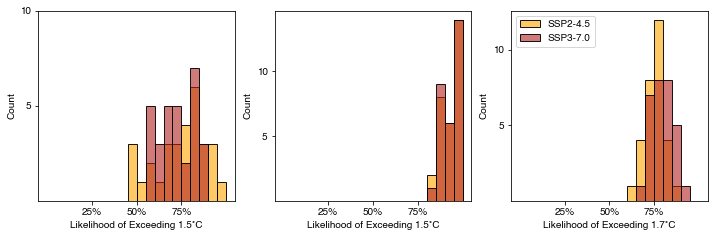

In [20]:
imp.reload(experiment_settings)
EXP_NAMES = ['chosen1_245', 'chosen5_245', 'chosen10_245', 'chosen1_370', 'chosen5_370', 'chosen10_370']

fig = plt.figure(figsize=(12,3.5))
colors = ['orange', 'firebrick']
threshes = [1.5, 1.5, 1.7]

settings = experiment_settings.get_settings(EXP_NAMES[0])
settings["obsdata"] = 'BEST'
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
end_year = da_obs.time.dt.year.values.max()
obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)

# Calculations
y_obs, ann_mean_obs = calc_y_obs(global_mean_vals = global_mean_obs)
obs_baseline = ann_mean_obs.values[np.logical_and(obs_yrs<=settings['anomaly_yr_bounds'][1], obs_yrs>=settings['anomaly_yr_bounds'][0])].mean() # To adjust network predictions

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    color = colors[iEXP//3]
    thresh = threshes[iEXP%3]
    settings = experiment_settings.get_settings(EXP_NAME)

    WINDOW_LEN = str(settings['len_window'])

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'

    full_model_list = []
    baseline_model_list = []
    delta_model_list = []
    model_settings_list = []

    for name in sorted(os.listdir(latest_exp_directory)):
        if os.path.isdir(latest_exp_directory + name):
            print(latest_exp_directory + name)
            full_model_list.append(file_methods.load_tf_model(name, latest_exp_directory))
        elif name.endswith('metadata.json'):
            print(latest_exp_directory + name)
            model_settings_list.append(file_methods.load_settings_model(name, latest_exp_directory))

    plt.subplot(1,3,iEXP%3 + 1)
    probs = []
    for full_model in full_model_list:
    
        musig = full_model.predict(x_obs[-1:]).squeeze()
        mu = musig[0] + obs_baseline
        sig = musig[1]

        z = (thresh - (mu))/sig
        prob = stats.norm.sf(z)
        probs.append(prob)

    if '245' in EXP_NAME:
        label='SSP2-4.5'
    else:
        label='SSP3-7.0'
    sb.histplot(probs, color=color, alpha=.6, binrange=[0,1], binwidth=.05, label=label)
    plt.xticks([.25, .5, .75], ['25%', '50%', '75%'])
    plt.yticks([5, 10])
    plt.xlabel('Likelihood of Exceeding ' + str(thresh) + '˚C')
plt.legend()
plt.savefig(dir + 'S_compareSSP_' + settings['obsdata'] + '2023.png', dpi=300)
plt.show()

# Figure 4, Figure S5 - Explainability Maps

In [9]:
settings = experiment_settings.get_settings("chosen1")
settings["obsdata"] = 'BEST'
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
lat = da_obs.lat
lon = da_obs.lon
end_year = da_obs.time.dt.year.values.max()
obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)

def get_gradients(model, inputs, baseline_inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model([inputs, baseline_inputs], training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            #preds = preds[:, top_pred_idx]
            preds = preds[top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(model, inputs, baseline_inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    input_size = np.shape(inputs)[1:]
    if baseline is None:
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = np.full(input_size, baseline).astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(model, x_data, baseline_inputs, top_pred_idx=top_pred_idx)
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def calc_xai(x, musigmaidx, top_pred_idx=None):
    inputs1, inputs2 = get_delta_input(baseline_model, x)
    xai = get_integrated_gradients(delta_model, inputs1, inputs2, baseline=musigmaidx, num_steps=50, top_pred_idx=top_pred_idx)  
    return  xai

def get_delta_input(baseline_model, x_test):
    map_input = x_test[..., 1:]
    baseline_input = np.stack(baseline_model(x_test[..., 0]), axis=-1).squeeze(axis=1)

    return (map_input, baseline_input,)

observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)


In [10]:
EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
plt.figure(figsize=(5,8))

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)
    baseline_model = full_model.get_layer("baseline_model")
    delta_model = full_model.get_layer("delta_model")

    # get the data
    (x_train, 
        x_val, 
        x_test, 
        y_train, 
        y_val, 
        y_test, 
        onehot_train, 
        onehot_val, 
        onehot_test, 
        y_yrs_train, 
        y_yrs_val, 
        y_yrs_test, 
        target_years, 
        map_shape,
        settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)

CanESM5_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
INM-CM5-0_r1i1p1f1
MRI-ESM2-0_r1i1p1f1
NorESM2-LM_r1i1p1f1
ACCESS-CM2_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
CESM2-WACCM_r1i1p1f1
FGOALS-g3_r1i1p1f1
MIROC-ES2L_r1i1p1f2
IITM-ESM_r1i1p1f1
CNRM-CM6-1_r1i1p1f2
ACCESS-ESM1-5_r1i1p1f1
FGOALS-f3-L_r1i1p1f1
INM-CM4-8_r1i1p1f1
CAS-ESM2-0_r1i1p1f1
MPI-ESM1-2-LR_r10i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
NorESM2-MM_r1i1p1f1
TaiESM1_r1i1p1f1
CESM2_r10i1p1f1
GISS-E2-1-G_r1i1p1f2
CMCC-ESM2_r1i1p1f1
KACE-1-0-G_r1i1p1f1
UKESM1-0-LL_r1i1p1f2
CMCC-CM2-SR5_r1i1p1f1
IPSL-CM5A2-INCA_r1i1p1f1
MIROC6_r1i1p1f1
GFDL-ESM4_r1i1p1f1
AWI-CM-1-1-MR_r1i1p1f1
CanESM5_r1i1p1f1
BCC-CSM2-MR_r1i1p1f1
INM-CM5-0_r1i1p1f1
MRI-ESM2-0_r1i1p1f1
NorESM2-LM_r1i1p1f1
ACCESS-CM2_r1i1p1f1
IPSL-CM6A-LR_r1i1p1f1
CESM2-WACCM_r1i1p1f1
FGOALS-g3_r1i1p1f1
MIROC-ES2L_r1i1p1f2
IITM-ESM_r1i1p1f1
CNRM-CM6-1_r1i1p1f2
ACCESS-ESM1-5_r1i1p1f1
FGOALS-f3-L_r1i1p1f1
INM-CM4-8_r1i1p1f1
CAS-ESM2-0_r1i1p1f1
MPI-ESM1-2-LR_r10i1p1f1
CNRM-CM6-1-HR_r1i1p1f2
NorESM2-MM_r1i1p1f1
TaiESM1

<Figure size 360x576 with 0 Axes>

### XAI for mu (observations)

/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/Jamin/miniforge3/envs/temp/lib/py

chosen1
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.62603354]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1557009]], dtype=float32)>)
[[0.5594082  0.09780526]]
[[0.7725047  0.08863834]]
chosen5
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8640004]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1282783]], dtype=float32)>)
[[0.82586795 0.11610194]]
[[0.8895761  0.11858925]]
chosen10
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0452282]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.14517444]], dtype=float32)>)
[[1.0354301  0.14517444]]
[[1.0542694  0.14517444]]


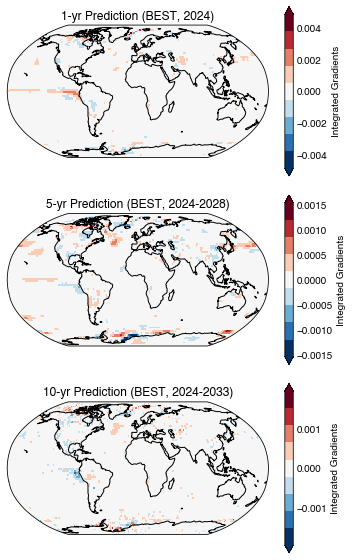

In [18]:
EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
plt.figure(figsize=(5,8))

# do linear regression of the obs to get a mean sample
obs_maps = x_obs[..., 1]
obs_predictors = x_obs[:, 0, 0]

mean_map = np.zeros_like(obs_maps[0, :])
for i in range(obs_maps.shape[1]):
    m, b = np.polyfit(obs_predictors, obs_maps[:,i], 1)
    mean_map[i] = obs_predictors[-1] * m + b

average_map = x_obs[-1:,...].copy()
average_map[..., 1] = mean_map

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)
    settings['obsdata'] = 'BEST'

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)
    baseline_model = full_model.get_layer("baseline_model")
    delta_model = full_model.get_layer("delta_model")
    
    ax = plt.subplot(3,1,iEXP+1, projection=ccrs.Robinson())
    xai = calc_xai(x_obs[obs_yrs==2023], average_map[0, ..., 1:], top_pred_idx = 0)
    xai_map = np.mean(np.array(xai), axis=(0,2)).reshape(map_shape[:-1])
    absmax = abs(xai_map).max() * .9
    colors = plt.cm.RdBu_r(np.linspace(0, 1, 9))
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    plt.pcolormesh(da_obs.lon, da_obs.lat, xai_map, cmap=cmap, vmin=-absmax,vmax=absmax, transform=ccrs.PlateCarree(), )
    cbar = plt.colorbar(label='Integrated Gradients', extend='both')
    cbar.ax.tick_params(size=0)

    ax.coastlines(color='k')
    if settings['len_window'] != 1:
        plt.title(str(settings['len_window']) + '-yr Prediction (' + settings['obsdata'] + ', 2024-' + str(2024+settings['len_window']-1) + ')')
    else:
        plt.title(str(settings['len_window']) + '-yr Prediction (' + settings['obsdata'] + ', 2024)')

    # Test a zero prediction
    print(EXP_NAME)
    print(baseline_model(average_map[...,0]))
    print(full_model.predict(average_map))
    print(full_model.predict(x_obs[-1:]))
plt.tight_layout()
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_XAI_' + settings['obsdata'] + '2023.png', dpi=300)
plt.show()

### XAI for sigma (observations)

chosen1
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.62603354]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1557009]], dtype=float32)>)
[[0.5594082  0.09780526]]
[[0.7725047  0.08863834]]
chosen5
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8640004]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1282783]], dtype=float32)>)
[[0.82586795 0.11610194]]
[[0.8895761  0.11858925]]
chosen10
(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0452282]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.14517444]], dtype=float32)>)
[[1.0354301  0.14517444]]
[[1.0542694  0.14517444]]


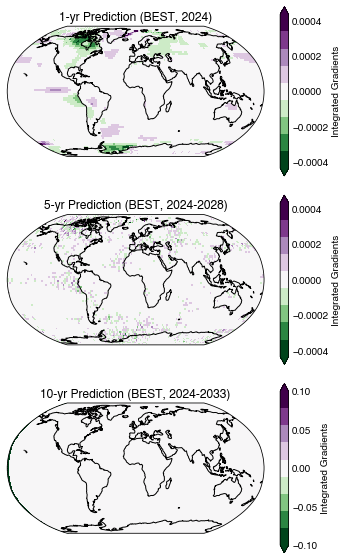

In [19]:
EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
plt.figure(figsize=(5,8))

# do linear regression of the obs to get a mean sample
obs_maps = x_obs[..., 1]
obs_predictors = x_obs[:, 0, 0]

mean_map = np.zeros_like(obs_maps[0, :])
for i in range(obs_maps.shape[1]):
    m, b = np.polyfit(obs_predictors, obs_maps[:,i], 1)
    mean_map[i] = obs_predictors[-1] * m + b

average_map = x_obs[-1:,...].copy()
average_map[..., 1] = mean_map

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)
    settings['obsdata'] = 'BEST'

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)
    baseline_model = full_model.get_layer("baseline_model")
    delta_model = full_model.get_layer("delta_model")
    
    ax = plt.subplot(3,1,iEXP+1, projection=ccrs.Robinson())
    xai = calc_xai(x_obs[obs_yrs==2023], average_map[0, ..., 1:], top_pred_idx = 1)
    xai_map = np.mean(np.array(xai), axis=(0,2)).reshape(map_shape[:-1])
    absmax = abs(xai_map).max() * .9
    colors = plt.cm.PRGn_r(np.linspace(0, 1, 9))
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    plt.pcolormesh(da_obs.lon, da_obs.lat, xai_map, cmap=cmap, vmin=-absmax,vmax=absmax, transform=ccrs.PlateCarree(), )
    cbar = plt.colorbar(label='Integrated Gradients', extend='both')
    cbar.ax.tick_params(size=0)

    ax.coastlines(color='k')
    if settings['len_window'] != 1:
        plt.title(str(settings['len_window']) + '-yr Prediction (' + settings['obsdata'] + ', 2024-' + str(2024+settings['len_window']-1) + ')')
    else:
        plt.title(str(settings['len_window']) + '-yr Prediction (' + settings['obsdata'] + ', 2024)')

    # Test a zero prediction
    print(EXP_NAME)
    print(baseline_model(average_map[..., 0]))
    print(full_model.predict(average_map))
    print(full_model.predict(x_obs[-1:]))
plt.tight_layout()
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_XAIsig_' + settings['obsdata'] + '2023.png', dpi=300)
plt.show()

# Figure S2 - delta mu and epsilon in validation data and observations

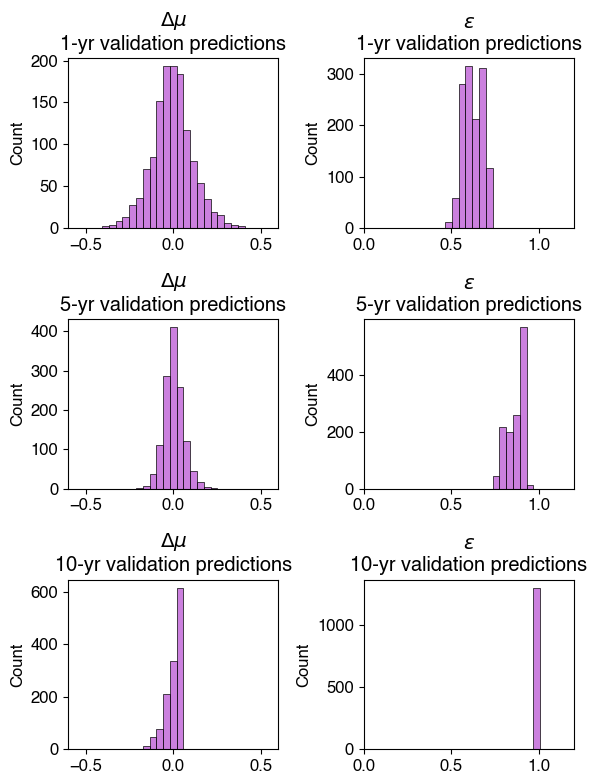

In [13]:
EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
plt.figure(figsize=(6,8))

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)
    baseline_model = full_model.get_layer("baseline_model")
    delta_model = full_model.get_layer("delta_model")

    # get the data
    (x_train, 
        x_val, 
        x_test, 
        y_train, 
        y_val, 
        y_test, 
        onehot_train, 
        onehot_val, 
        onehot_test, 
        y_yrs_train, 
        y_yrs_val, 
        y_yrs_test, 
        target_years, 
        map_shape,
        settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)
    
    ax1 = plt.subplot(3,2,iEXP*2+1)
    ax2 = plt.subplot(3,2,iEXP*2+2)
    
    this_predictions = delta_predict(delta_model, baseline_model, x_val)
    dist_func = sb.histplot
    ax1.set_title('$\Delta\mu$\n' + str(settings['len_window']) + '-yr validation predictions')
    ax1.set_xlim(-.6, .6)
    dist_func(this_predictions[0].flatten(), ax=ax1, bins=31, binrange=[-.6, .6], color='mediumorchid')
    ax2.set_title('$\epsilon$\n' + str(settings['len_window']) + '-yr validation predictions')
    ax2.set_xlim(0, 1.2)
    dist_func(this_predictions[1].flatten(), ax=ax2, bins=31, binrange=[0, 1.2], color='mediumorchid')
plt.tight_layout()
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_deltamu_epsilon_distributions.png', dpi=300)
plt.show()

observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
-0.17652991 0.22264826 0.49700916 0.6428459
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
-0.08310691 0.14302947 0.8012574 0.9244685
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
-0.057796225 0.038007125 1.0 1.0


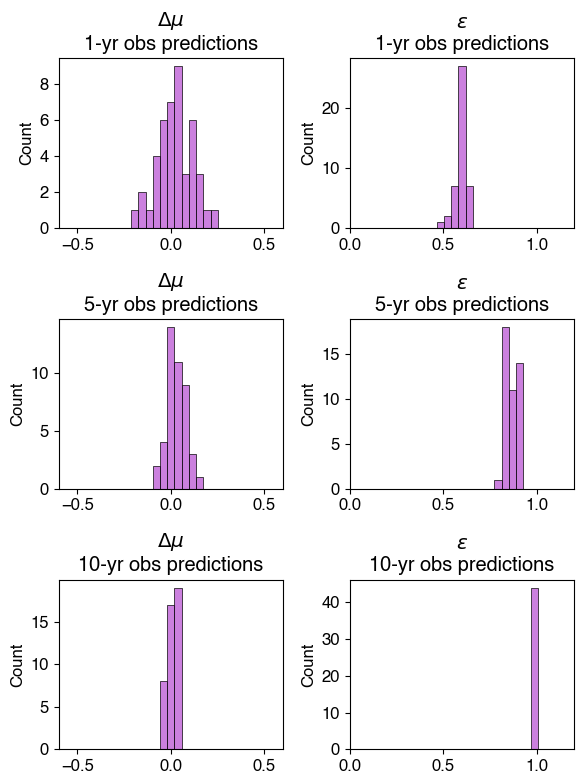

In [109]:
EXP_NAMES = ['chosen1', 'chosen5', 'chosen10']
plt.figure(figsize=(6,8))

for iEXP, EXP_NAME in enumerate(EXP_NAMES):

    settings = experiment_settings.get_settings(EXP_NAME)

    trained_exps = []
    for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
        if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
            trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

    latest_exp_directory = sorted(trained_exps)[-1] + '/'
    filename = EXP_NAME  + '_seed'+ str(settings['seed']) + '_model'
    full_model= file_methods.load_tf_model(filename, latest_exp_directory)
    baseline_model = full_model.get_layer("baseline_model")
    delta_model = full_model.get_layer("delta_model")

    settings["obsdata"] = 'BEST'
    da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
    
    ax1 = plt.subplot(3,2,iEXP*2+1)
    ax2 = plt.subplot(3,2,iEXP*2+2)
    
    this_predictions = delta_predict(delta_model, baseline_model, x_obs[da_obs.time.dt.year >= 1980])
    dist_func = sb.histplot
    ax1.set_title('$\Delta\mu$\n' + str(settings['len_window']) + '-yr obs predictions')
    ax1.set_xlim(-.6, .6)
    dist_func(this_predictions[0].flatten(), ax=ax1, bins=31, binrange=[-.6, .6], color='mediumorchid')
    ax2.set_title('$\epsilon$\n' + str(settings['len_window']) + '-yr obs predictions')
    ax2.set_xlim(0, 1.2)
    dist_func(this_predictions[1].flatten(), ax=ax2, bins=31, binrange=[0, 1.2], color='mediumorchid')
    print(np.min(this_predictions[0]), np.max(this_predictions[0]), np.min(this_predictions[1]), np.max(this_predictions[1]))
plt.tight_layout()
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_deltamu_epsilon_distributions_obs.png', dpi=300)
plt.show()

# Plot Figure S10 - Initial Tuning (Architectures)

/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

0.01
[2, 2, 2]
gelu


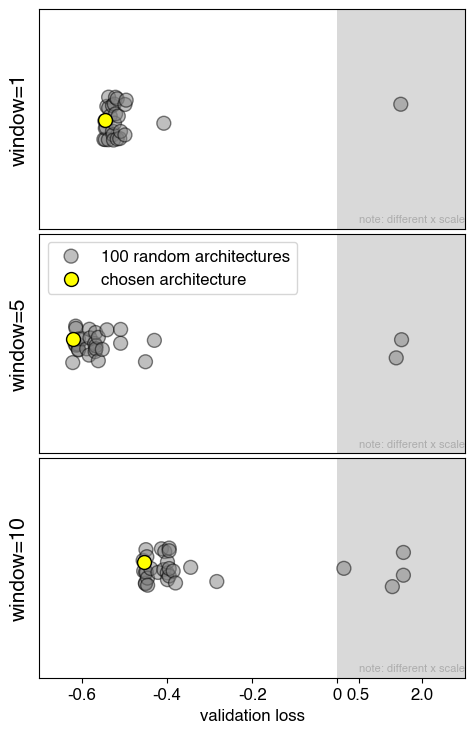

In [17]:
def custom_scale(data_list):
    new_data_list = []
    for d in data_list:
        thresh = 0
        if d <= thresh:
            newd = d
        else:
            newd = thresh + (d-thresh)/10
        new_data_list.append(newd)
    return new_data_list

seed_val = 17
iplot = 1
np.random.seed(4) # keep jitter constant
plt.figure(figsize = (5,7.5))
for win in ["1", "5", "10",]:
    plt.subplot(3,1,iplot)
    n_top = 30
    tuner_dict = get_best_models("basetune" + win, num_models=n_top, track_loss = 'test')
    sb.stripplot(custom_scale([tuner_dict[list(tuner_dict.keys())[i]]["results"]["test_loss"] for i in np.arange(n_top)]), 
                 edgecolor="black", alpha=.5, color='gray', size=10, linewidth=1, jitter=True)#.25)
    sb.stripplot(custom_scale([tuner_dict[seed_val]["results"]["test_loss"]]), 
                 edgecolor="black", alpha=1, color='yellow', size=10, linewidth=1, jitter=True)#.25)
    #plt.axvline(custom_scale([tuner_dict[seed_val]["results"]["test_loss"]]), color = 'k', zorder=0)
    plt.axvspan(custom_scale([0])[0], 1000, color = 'k', alpha=.15, linestyle='')
    plt.text(custom_scale([.5])[0], .47, 'note: different x scale', alpha=.2, size=8)
    plt.ylabel("window=" + win, size=15)
    xlims = custom_scale([-.7,3.])
    plt.xlim(xlims[0], xlims[1])
    plt.yticks([])

    if iplot == 2:
        plt.legend(['100 random architectures', 'chosen architecture'])
    if iplot == 3 or iplot == 4:
        plt.xlabel('validation loss')
        actual_ticks = [-.6,-.4,-.2, 0, .5, 2.0,]
        plt.xticks(custom_scale(actual_ticks), labels=actual_ticks)
    else:
        plt.xticks([])
    iplot += 1
plt.tight_layout(h_pad=0)

print(tuner_dict[seed_val]["baseline_learning_rate"])
print(tuner_dict[seed_val]["hiddens1"])
print(tuner_dict[seed_val]["act_fun1"])
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_baseline_loss_v_architecture.png', dpi=300)

# Plot Figure S11 - Initial Tuning (Train/Val Splits)

/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

{3: {'save_model': True, 'n_models': 30, 'ssp': '370', 'ensemble_data': False, 'gcmsub': 'ALL', 'obsdata': 'BEST', 'smooth': False, 'model_type': 'static_window', 'len_window': 1, 'n_train_val_test': (20, 10, 0), 'no_test': True, 'baseline_yr_bounds': (1980, 2010), 'training_yr_bounds': (1951, 2080), 'anomaly_yr_bounds': (1980, 2010), 'remove_sh': False, 'anomalies': True, 'remove_map_mean': False, 'input_fields': ('timemean=10_spatialmean=global', 'timemean=1'), 'network_type': 'shash2', 'hiddens1': (2, 2, 2), 'hiddens2': '[5, 5, 5]', 'hiddens3': '[1]', 'dropout_rate': 0.0, 'ridge_param1': 0, 'ridge_param2': 0.1, 'ridge_param3': 0, 'learning_rate': 0.01, 'baseline_learning_rate': 0.01, 'batch_size': 64, 'rng_seed': 0, 'seed': 181, 'act_fun1': 'gelu', 'act_fun2': 'tanh', 'act_fun3': 'tanh', 'n_epochs': 25000, 'patience': 50, 'exp_name': 'basetune1_singlearch', 'train_models': '[25, 29, 27, 13, 7, 28, 15, 18, 12, 11, 22, 19, 21, 24, 10, 17, 26, 8, 0, 9]', 'val_models': '[14, 1, 16, 2, 5

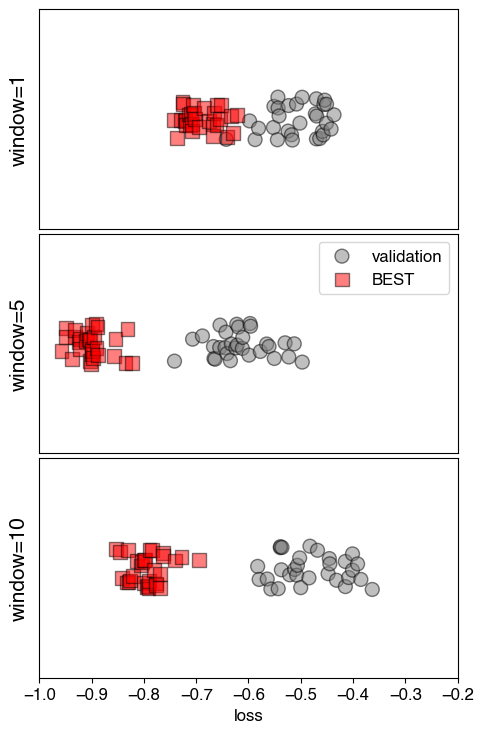

In [20]:
def custom_scale(data_list):
    new_data_list = []
    for d in data_list:
        thresh = np.Inf
        if d <= thresh:
            newd = d
        else:
            newd = thresh + (d-thresh)/10
        new_data_list.append(newd)
    return new_data_list

iplot = 1
np.random.seed(4) # keep jitter constant
plt.figure(figsize = (5,7.5))
for win in ["1", "5", "10"]:
    plt.subplot(3,1,iplot)
    n_top = 30
    plot_metric = "test"
    tuner_dict = get_best_models("basetune" + win + "_singlearch", num_models=n_top, track_loss = plot_metric)
    sb.stripplot(custom_scale([tuner_dict[list(tuner_dict.keys())[i]]["results"][plot_metric + "_loss"] for i in np.arange(n_top)]), 
                 edgecolor="black", alpha=.5, color='gray', size=10, linewidth=1, jitter=True)
    plot_metric = "obs"
    tuner_dict = get_best_models("basetune" + win + "_singlearch", num_models=n_top, track_loss = plot_metric)
    print(tuner_dict)
    ax = sb.stripplot(custom_scale([tuner_dict[list(tuner_dict.keys())[i]]["results"][plot_metric + "_loss"] for i in np.arange(n_top)]), 
                edgecolor="black", alpha=.5, color='red', size=10, linewidth=1, marker='s')
    #plt.axvspan(custom_scale([.5])[0], 1000, color = 'k', alpha=.15, linestyle='')
    #plt.text(custom_scale([.8])[0], .47, 'note: different x scale', alpha=.2, size=8)
    plt.ylabel("window=" + win, size=15)
    xlims = custom_scale([-1, -.2])
    plt.xlim(xlims[0], xlims[1])
    plt.yticks([])
    if iplot == 2:
        plt.legend(['validation', tuner_dict[list(tuner_dict.keys())[0]]['obsdata']])
    if iplot == 3 or iplot == 4:
        plt.xlabel('loss')
    else:
        plt.xticks([])
    iplot += 1
plt.tight_layout(h_pad=0)

dir = 'final_figures/supp/'
plt.savefig(dir + 'S_baseline_loss_v_split.png', dpi=300)

# Plot Figure S12 - Final Network Architecture Tuning

/Users/Jamin/miniforge3/envs/temp/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


52


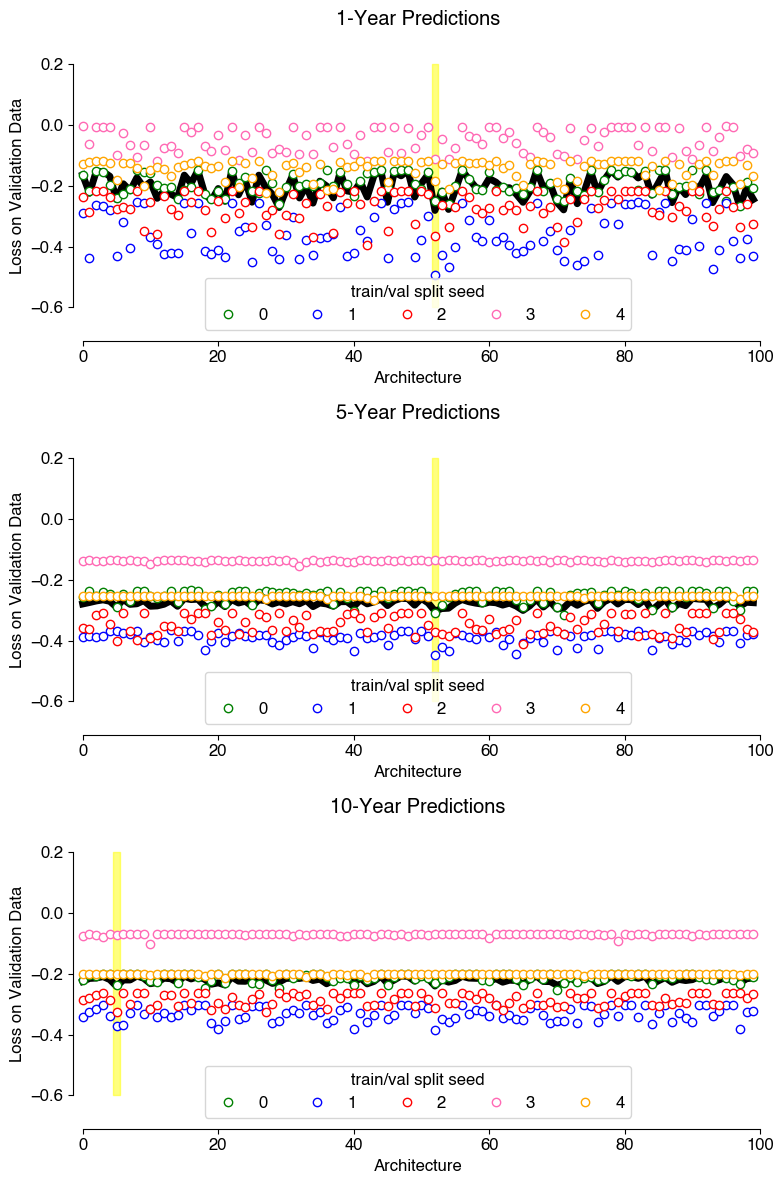

In [27]:
def plot_all_tune_metrics(list_of_exps, trackloss = "test", figsize = (8,4), include_mean=False, bltrackloss=None):
    icolor = 0
    colors = ['green', 'b', 'r', 'hotpink', 'orange']
    
    for_mean = []
    bl_for_mean = []
    for exp_name in list_of_exps:
        plottable = get_model_losses(exp_name, trackloss)
        plt.plot(plottable, 'o', color=colors[icolor], label=exp_name[-1], alpha=1, markerfacecolor="white")
        for_mean.append(plottable)
        if bltrackloss != None:
            plottable = get_model_losses(exp_name, bltrackloss)
            plt.plot(plottable, '--', color = colors[icolor])
            bl_for_mean.append(plottable)
        icolor += 1
    if include_mean:
        plt.plot(np.mean(np.array(bl_for_mean), axis=0), 'k--', alpha=0)
        plt.plot(np.mean(np.array(for_mean), axis=0), 'k-', linewidth=5, zorder=0)
    plt.legend(title='train/val split seed', ncol=5, loc="lower center")
    plt.xlim(-1, 100)
    plt.ylim(-.7, .3)
    if include_mean:
        return np.array(for_mean), np.array(bl_for_mean)
    
seed_range = 5

plt.figure(figsize=(8,12))

window_length = 1
plt.subplot(3,1,1)
lossmean, __ = plot_all_tune_metrics(["tune"+str(window_length)+"_" + str(i) for i in range(seed_range)], trackloss = "val",
                      include_mean=True, bltrackloss=None)#'bl_val')
plt.xlabel('Architecture')
plt.ylabel('Loss on Validation Data')
plt.title(str(window_length) + '-Year Predictions')
chosen = np.argmin(lossmean.mean(axis=0))
print(chosen)
plt.fill_between([chosen-.5, chosen+.5], [-.6, -.6], [.2, .2], color='yellow', alpha=.5, zorder= -1)
sb.despine(offset=2, trim=True)

window_length = 5
plt.subplot(3,1,2)
lossmean, __ = plot_all_tune_metrics(["tune"+str(window_length)+"_" + str(i) for i in range(seed_range)], trackloss = "val",
                      include_mean=True, bltrackloss=None)#'bl_val')
plt.xlabel('Architecture')
plt.ylabel('Loss on Validation Data')
plt.title(str(window_length) + '-Year Predictions')
chosen = np.argmin(lossmean.mean(axis=0))
plt.fill_between([chosen-.5, chosen+.5], [-.6, -.6], [.2, .2], color='yellow', alpha=.5, zorder= -1)
sb.despine(offset=2, trim=True)

window_length = 10
plt.subplot(3,1,3)
lossmean, __ = plot_all_tune_metrics(["tune"+str(window_length)+"_" + str(i) for i in range(seed_range)], trackloss = "val",
                      include_mean=True, bltrackloss=None)#'bl_val')
plt.xlabel('Architecture')
plt.ylabel('Loss on Validation Data')
plt.title(str(window_length) + '-Year Predictions',)
chosen = np.argmin(lossmean.mean(axis=0))
plt.fill_between([chosen-.5, chosen+.5], [-.6, -.6], [.2, .2], color='yellow', alpha=.5, zorder= -1)
sb.despine(offset=2, trim=True)
plt.tight_layout()
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_final_loss_v_architecture_and_split.png', dpi=300)
plt.show()

# Plot Figure S7/S8 - Tuning Final Model Selection (Initial Seeds + Train/Val Split)

In [3]:
import sys, imp, os, time

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd

import experiment_settings
import file_methods, plots, custom_metrics, network, data_processing, base_directories, shash_tfp

import matplotlib as mpl
import seaborn as sb
import cartopy.crs as ccrs
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

dir_settings = base_directories.get_directories()

MODEL_DIRECTORY = dir_settings['models']       
PREDICTIONS_DIRECTORY = dir_settings['predictions']   
DATA_DIRECTORY = dir_settings['data']   
DIAGNOSTICS_DIRECTORY = dir_settings['diagnostics']   
FIGURE_DIRECTORY = dir_settings['figure']   

def calc_y_obs(global_mean_map = None, global_mean_vals = None):
    assert global_mean_map is not None or global_mean_vals is not None, "One of the inputs to calc_y_obs must not be None"
    if global_mean_map != None:
        weights = np.cos(np.deg2rad(da_obs.lat))
        weights.name = "weights"
        da_obs_weighted = (global_mean_map).weighted(weights)
        global_mean_vals = da_obs_weighted.mean(["lat", "lon"])

    BEST_2023_mean = 1.54
    ann_mean_v_anom_diff = BEST_2023_mean - global_mean_vals[2023-end_year-1]
    ann_mean_anom_obs = global_mean_vals + ann_mean_v_anom_diff
    roll = settings['len_window']
    max_T_anom_obs = ann_mean_anom_obs.rolling(min_periods=roll, center=False, time=roll).max().shift(shifts={"time":-roll})
    return max_T_anom_obs, ann_mean_anom_obs

In [4]:
OBS_DATA = 'BEST'
best_model_settings = []
losses_arr_list = [] # For use in the cell below comparing to PITD
probs_arr_list = []
PITDs_arr_list = []
all_settings_list = []

THRESHES = {1:1.5, 5:1.5, 10:1.7}

WINDOW_LENS = [1, 5, 10]

for WINDOW_LEN in WINDOW_LENS:

    EXP_NAMES = ["top" + str(WINDOW_LEN) + "_best_" + str(i) for i in np.arange(10)] 

    list_of_full_model_lists = []
    list_of_model_settings_lists = []


    first_pass = True

    for EXP_NAME in EXP_NAMES:
        
        trained_exps = []
        for name in os.listdir(MODEL_DIRECTORY + EXP_NAME + '/'):
            if os.path.isdir(MODEL_DIRECTORY + EXP_NAME + '/' + name):
                trained_exps.append(MODEL_DIRECTORY + EXP_NAME + '/' + name)

        latest_exp_directory = sorted(trained_exps)[-1] + '/'

        full_model_list = []
        model_settings_list = []

        for name in sorted(os.listdir(latest_exp_directory)):
            if os.path.isdir(latest_exp_directory + name):
                full_model_list.append(file_methods.load_tf_model(name, latest_exp_directory))
            elif name.endswith('metadata.json'):
                settings = file_methods.load_settings_model(name, latest_exp_directory).copy()
                model_settings_list.append(settings.copy())
        list_of_full_model_lists.append(full_model_list)
        list_of_model_settings_lists.append(model_settings_list)

    settings = experiment_settings.get_settings(EXP_NAME).copy()
    ## choose observations
    settings["obsdata"] = OBS_DATA
    METRIC = 'loss'
    da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)

    # params
    end_year = da_obs.time.dt.year.values.max()
    obs_metric_start_year = 1980
    obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)

    # Calculations
    y_obs, ann_mean_obs = calc_y_obs(global_mean_vals = global_mean_obs)
    obs_baseline = ann_mean_obs.values[np.logical_and(obs_yrs<=settings['anomaly_yr_bounds'][1], obs_yrs>=settings['anomaly_yr_bounds'][0])].mean() # To adjust network predictions
    y_obs = y_obs.values

    for PINATUBO_BOOL in [True, False]:

        obs_selector = np.logical_and(obs_yrs>=1980, obs_yrs<=2020-settings["len_window"])
        if not PINATUBO_BOOL:
            no_pinatubo_bool = np.logical_or(obs_yrs < 1991-settings["len_window"], obs_yrs >= 1996)
            obs_selector = np.logical_and(obs_selector, no_pinatubo_bool)
        x_obs_val = x_obs[obs_selector]
        y_obs_val = y_obs[obs_selector]

        # Calculate Metrics
        list_of_obs_losses = []
        list_of_probs = []
        list_of_PITDs = []
        thresh = THRESHES[settings['len_window']]

        for iEXP in range(len(EXP_NAMES)):
            validation_losses = []
            obs_losses = []
            validation_maes = []
            probs = []
            PITDs = []
            for imodel, full_model, settings in zip(range(len(list_of_full_model_lists[iEXP])), list_of_full_model_lists[iEXP], list_of_model_settings_lists[iEXP]):
                full_model.compile(metrics=[network.RegressLossExpSigma])

                (__, 
                x_val, 
                x_test, 
                y_train, 
                y_val, 
                y_test, 
                onehot_train, 
                onehot_val, 
                onehot_test, 
                y_yrs_train, 
                y_yrs_val, 
                y_yrs_test, 
                target_years, 
                map_shape,
                settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)

                # Calculate PITD
                p = full_model.predict(x_val, verbose=0)
                dist = shash_tfp.Shash(p[:, 0], p[:, 1]) #, p[:, 2], p[:, 3])
                F = dist.cdf(onehot_val[:, 0])
                bins = np.linspace(0, 1, 11)
                pit_hist = np.histogram(
                    F,
                    bins=bins,
                    weights=np.ones_like(F) / float(len(F)),
                )
                # PIT metric from Bourdin et al. (2014) and Nipen and Stull (2011).
                # Also, compute expected deviation of PIT for a perfect forecast.
                B = len(pit_hist[0])
                PITD = np.sqrt(1 / B * np.sum((pit_hist[0] - 1 / B) ** 2))
                EDp = np.sqrt((1. - 1 / B) / (onehot_val.shape[0] * B))

                # Calculate probabilities
                mu, sig = full_model.predict(x_obs[-1:,...])[0]
                z = (thresh - (mu + obs_baseline))/sig
                prob = stats.norm.sf(z)
                
                # Calculate loss on observations
                obs_loss = full_model.evaluate(x_obs_val, y_obs_val-obs_baseline, verbose=0)[1]

                # Append everything
                obs_losses.append(obs_loss)
                probs.append(prob)
                PITDs.append(PITD)
            
            list_of_obs_losses.append(obs_losses)
            list_of_probs.append(probs)
            list_of_PITDs.append(PITDs)

        obs_losses_arr = np.array(list_of_obs_losses)
        probs_arr = np.array(list_of_probs)
        PITDs_arr = np.array(list_of_PITDs)
        losses_arr = obs_losses_arr
        losses_arr_list.append(losses_arr)
        probs_arr_list.append(probs_arr)
        PITDs_arr_list.append(PITDs_arr)
        all_settings_list.append(list_of_model_settings_lists)

observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)


In [5]:
# Identify the network for the paper based on validation PITD and decent performance on observation
model_select = 'loss+pitd'

PITDs_arr_arr = np.array(PITDs_arr_list)
losses_arr_arr = np.array(losses_arr_list)

best_model_idxs = []
best_model_percentiles = []

if model_select == 'loss+pitd':
    for losses_arr, PITDs_arr in zip(losses_arr_arr, PITDs_arr_arr):
        for percentile in np.arange(1, 100):
            best_model_idx = np.argwhere(np.logical_and(losses_arr <= np.percentile(losses_arr, percentile),
                                    PITDs_arr <= np.percentile(PITDs_arr, percentile)))
            if len(best_model_idx > 0):
                if len(best_model_idx) > 1:
                    best_model_idx = best_model_idx[0]
                break
        best_model_idxs.append(best_model_idx)
        best_model_percentiles.append(percentile)
    print(best_model_percentiles)
    print(best_model_idxs)
elif model_select == 'loss':
    for losses_arr in losses_arr_arr:
        best_model_idx = np.argwhere(losses_arr == np.min(losses_arr))
        best_model_idxs.append(best_model_idx)
BEST_SPLIT_SEEDS = [b.squeeze()[1] for b in best_model_idxs]
BEST_INIT_SEEDS = [b.squeeze()[0] for b in best_model_idxs]

[12, 17, 11, 10, 9, 6]
[array([[6, 5]]), array([[7, 7]]), array([[7, 5]]), array([0, 2]), array([[8, 0]]), array([[2, 0]])]


In [23]:
# Identify the network for the paper based on validation PITD and decent performance on observation
ptile = 25
np.argwhere(np.logical_and(\
    np.logical_and(losses_arr_arr[4] <= np.percentile(losses_arr_arr[4], [ptile]), PITDs_arr_arr[4] <= np.percentile(PITDs_arr_arr[4], ptile)),
    abs(probs_arr_list[4] - .8) < .05))

array([[8, 8]])

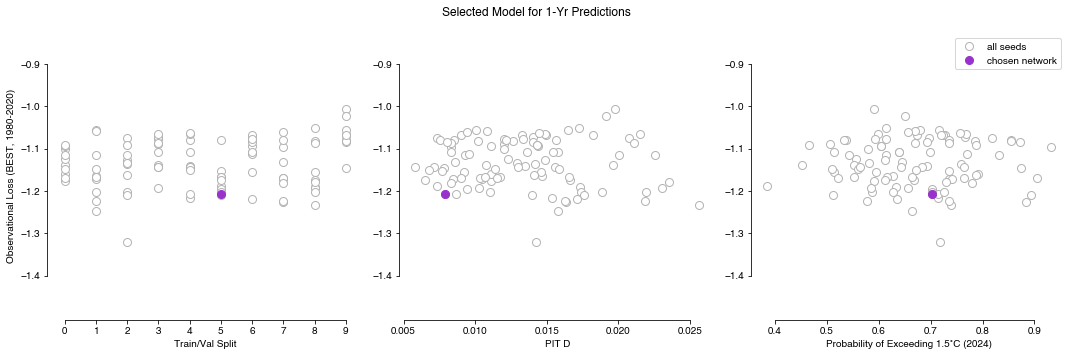

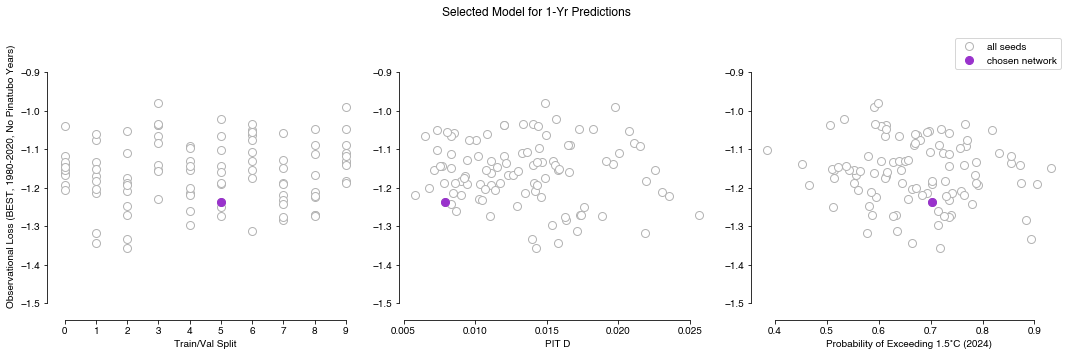

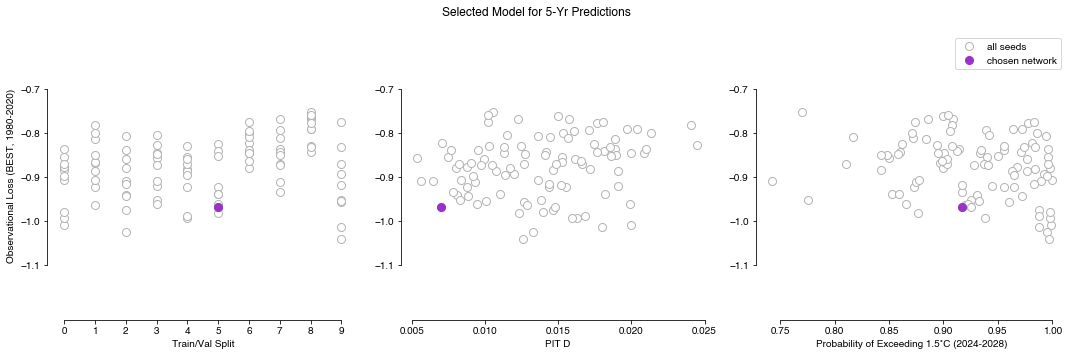

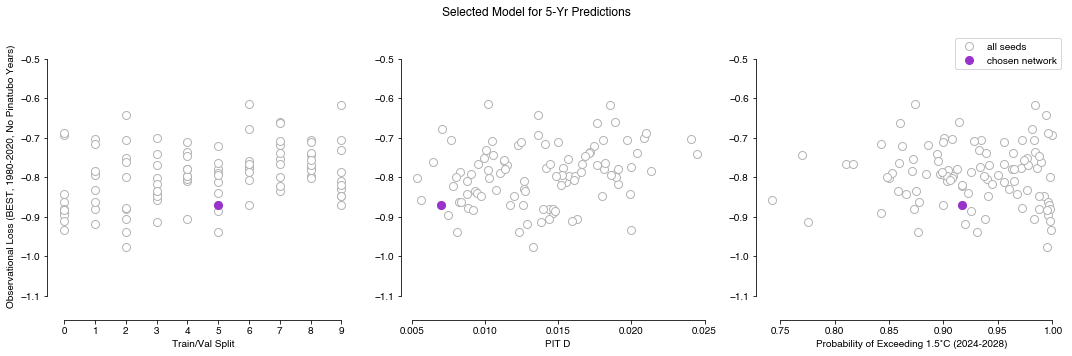

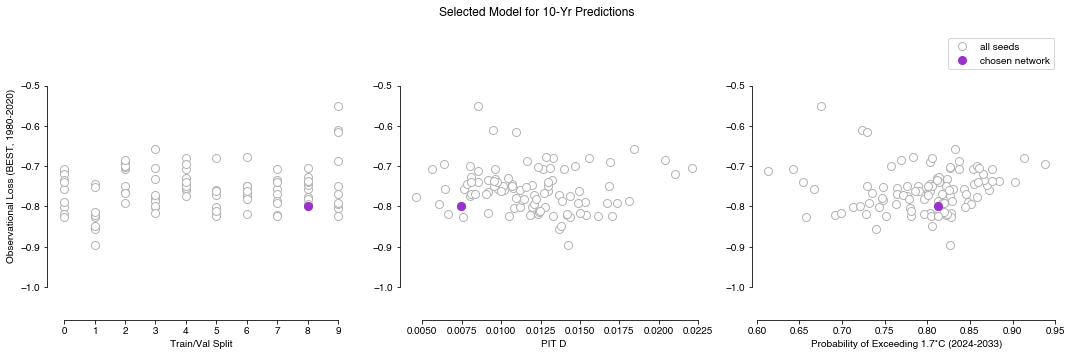

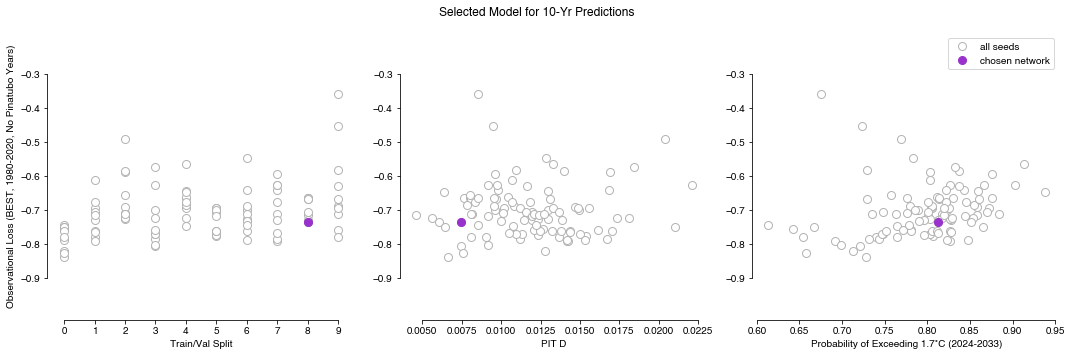

In [27]:
PITDs_arr_arr = np.array(PITDs_arr_list)
losses_arr_arr = np.array(losses_arr_list)
probs_arr_arr = np.array(probs_arr_list)

BEST_SPLIT_SEEDS = [BEST_SPLIT_SEEDS[i - i%2] for i in range(len(BEST_SPLIT_SEEDS))]
BEST_INIT_SEEDS = [BEST_INIT_SEEDS[i - i%2] for i in range(len(BEST_INIT_SEEDS))]

# Modifying for a 10-yr network that is representative of all the networks trained
BEST_SPLIT_SEEDS[-2] = 8
BEST_INIT_SEEDS[-2] = 8
BEST_SPLIT_SEEDS[-1] = 8
BEST_INIT_SEEDS[-1] = 8

THRESHES = {1:1.5, 5:1.5, 10:1.7}
pinatubo_bools = [True, False, True, False, True, False]
WINDOW_LENS = [1,1, 5, 5, 10, 10]

# Making the Plot
for losses_arr, PITDs_arr, probs_arr, best_init_seed_idx, best_split_seed_idx, WINDOW_LEN, pinatubo_bool \
    in zip(losses_arr_arr, PITDs_arr_arr, probs_arr_arr, BEST_INIT_SEEDS, BEST_SPLIT_SEEDS, WINDOW_LENS, pinatubo_bools):

    color = "darkorchid"
    color2 = '.7'
    ms = 8
    mew = 1

    thresh = THRESHES[WINDOW_LEN]

    best_loss = losses_arr[best_init_seed_idx, best_split_seed_idx]
    best_prob = probs_arr[best_init_seed_idx, best_split_seed_idx]
    best_PITD = PITDs_arr[best_init_seed_idx, best_split_seed_idx]

    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.plot(losses_arr.T, 'o', color=color2, markerfacecolor='white', ms=ms, label='all seeds')
    #plt.plot([selected_seeds_i]*len(best_losses_arr), best_losses_arr, 'o', markerfacecolor='white', color=color, ms=ms, label='best train/val split')
    plt.plot(best_split_seed_idx, best_loss, 'o', color=color, ms=ms, mew=mew)
    plt.xlabel('Train/Val Split')
    plt.xticks(range(10))
    if pinatubo_bool:
        plt.ylabel('Observational Loss ('+OBS_DATA+', 1980-2020)')
    else:
        plt.ylabel('Observational Loss ('+OBS_DATA+', 1980-2020, No Pinatubo Years)')
    ymin = np.min(losses_arr)
    ymax = np.max(losses_arr)
    plt.yticks(np.arange(np.round(ymin-.1,decimals=1),np.round(ymax+.1,decimals=1)+.001, .1))
    plt.ylim(ymin-.18, ymax+.18)
    plt.xlim(-.5,9.5)
    sb.despine(offset=2, trim=True)

    plt.subplot(1,3,2)
    plt.plot(PITDs_arr.flatten(), losses_arr.flatten(), 'o', color=color2, markerfacecolor='white', ms=ms, label='all seeds')
    plt.plot(best_PITD, best_loss, 'o', color = color, ms=ms, mew=mew, label='chosen network')
    plt.xlabel('PIT D')

    plt.yticks(np.arange(np.round(ymin-.1,decimals=1),np.round(ymax+.1,decimals=1)+.001, .1))
    plt.ylim(ymin-.18, ymax+.18)

    plt.subplot(1,3,3)
    plt.plot(probs_arr.flatten(), losses_arr.flatten(), 'o', color=color2, markerfacecolor='white', ms=ms, label='all seeds')
    #plt.plot(best_probs_arr, best_losses_arr, 'o', color = color, markerfacecolor='white', alpha=.9, ms=ms, label='best train/val split')
    plt.plot(best_prob, best_loss, 'o', color = color, ms=ms, mew=mew, label='chosen network')
    if WINDOW_LEN == 1:
        plt.xlabel('Probability of Exceeding ' + str(thresh) + '˚C (2024)')
    else:
        plt.xlabel('Probability of Exceeding ' + str(thresh) + '˚C (2024-' + str(2024 + WINDOW_LEN - 1) + ')')

    plt.yticks(np.arange(np.round(ymin-.1,decimals=1),np.round(ymax+.1,decimals=1)+.001, .1))
    plt.ylim(ymin-.18, ymax+.18)

    plt.legend()#, 'best seed', 'chosen model'])

    sb.despine(offset=2, trim=True)
    plt.suptitle('Selected Model for ' + str(WINDOW_LEN) + '-Yr Predictions')
    plt.tight_layout()
    dir = 'final_figures/supp/'
    if pinatubo_bool:
        plt.savefig(dir + 'S_choosing_the_final_model_' + str(WINDOW_LEN) + 'yrs.png', dpi=300)
    else:
        plt.savefig(dir + 'S_choosing_the_final_model_' + str(WINDOW_LEN) + 'yrs_nopinatubo.png', dpi=300)
    plt.show()

In [26]:
# Print out the best seeds from tuning

print('Window 1:')
exp_idx = 0
settings = all_settings_list[exp_idx][BEST_INIT_SEEDS[exp_idx]][BEST_SPLIT_SEEDS[exp_idx]]
print(settings["seed"], settings["init_seed"])
print('Window 5:')
exp_idx = 2
settings = all_settings_list[exp_idx][BEST_INIT_SEEDS[exp_idx]][BEST_SPLIT_SEEDS[exp_idx]]
print(settings["seed"], settings["init_seed"])
print('Window 10:')
exp_idx = 4
settings = all_settings_list[exp_idx][BEST_INIT_SEEDS[exp_idx]][BEST_SPLIT_SEEDS[exp_idx]]
print(settings["seed"], settings["init_seed"])

Window 1:
3770 6
Window 5:
3770 7
Window 10:
8319 8


# Looking at the raw climate model data

In [1]:
import data_processing
import file_methods
import base_directories
import experiment_settings
import imp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import cartopy.crs as ccrs

imp.reload(experiment_settings)
imp.reload(data_processing)

import matplotlib as mpl
import seaborn as sb
import cartopy.crs as ccrs
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 200
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)

2.7.0
0.15.0


In [2]:
experiment_name = 'oneyearmeans_versus_19802010'

directories = base_directories.get_directories()
settings = experiment_settings.get_settings(experiment_name)

filenames = file_methods.get_cmip_filenames(settings, directories['data'], verbose=0)

for i,f in enumerate(filenames):
    print(i, f[0].split('_')[3])

0 CanESM5
1 BCC-CSM2-MR
2 INM-CM5-0
3 MRI-ESM2-0
4 NorESM2-LM
5 ACCESS-CM2
6 IPSL-CM6A-LR
7 CESM2-WACCM
8 FGOALS-g3
9 MIROC-ES2L
10 IITM-ESM
11 CNRM-CM6-1
12 ACCESS-ESM1-5
13 FGOALS-f3-L
14 INM-CM4-8
15 CAS-ESM2-0
16 MPI-ESM1-2-LR
17 CNRM-CM6-1-HR
18 NorESM2-MM
19 TaiESM1
20 CESM2
21 GISS-E2-1-G
22 CMCC-ESM2
23 KACE-1-0-G
24 UKESM1-0-LL
25 CMCC-CM2-SR5
26 IPSL-CM5A2-INCA
27 MIROC6
28 GFDL-ESM4
29 AWI-CM-1-1-MR


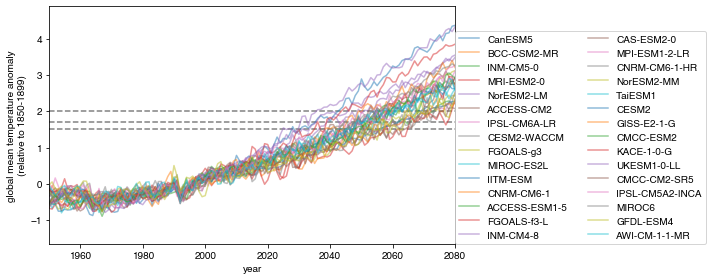

-0.8933579624068102
4.364887666924915


In [5]:
# get the data
(x_train, 
    x_val, 
    x_test, 
    y_train, 
    y_val, 
    y_test, 
    onehot_train, 
    onehot_val, 
    onehot_test, 
    y_yrs_train, 
    y_yrs_val, 
    y_yrs_test, 
    target_years, 
    map_shape,
    settings) = data_processing.get_cmip_data(directories['data'], settings, verbose=0)

y_all = np.concatenate([y_train, y_val, y_test], axis=0)
N_GCMS = len(filenames)
y_all = y_all.reshape(N_GCMS, -1)

model_names = [filename[0].split('_')[3] for filename in filenames]
yrs_for_globalmeantemp = y_yrs_train[:y_all.shape[1]] + 1 # +1 to years, because we are looking 1 year in advance
plt.figure(figsize=(10, 4))
plt.plot(yrs_for_globalmeantemp, y_all.T, alpha = .5) 
plt.legend(model_names, loc=(1,0), ncol=2, fontsize=10)
plt.ylabel('global mean temperature anomaly\n(relative to 1850-1899)')
plt.xlabel('year')
for thresh in [1.5, 1.7, 2.0]:
    plt.axhline(thresh, color='gray', linestyle = '--', zorder = 0)
plt.xlim(1950, 2080)
dir = 'final_figures/supp/'
plt.tight_layout()
plt.savefig(dir + 'S_raw_climate_models.png', dpi=300)
plt.show()

In [26]:
settings["obsdata"] = 'BEST'
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
lat = da_obs.lat.values
lon = da_obs.lon.values

# params
end_year = da_obs.time.dt.year.values.max()
obs_metric_start_year = 1980
obs_yrs = np.arange(end_year-x_obs.shape[0]+1, end_year+1)

# Calculations
y_obs, ann_mean_obs = calc_y_obs(global_mean_vals = global_mean_obs)

print(y_all.T[np.logical_and(yrs_for_globalmeantemp>=1950, yrs_for_globalmeantemp<=2080)].min()+y_obs[np.logical_and(obs_yrs>=1980, obs_yrs<=2010)].mean())
print(y_all.T[np.logical_and(yrs_for_globalmeantemp>=1950, yrs_for_globalmeantemp<=2080)].max()+y_obs[np.logical_and(obs_yrs>=1980, obs_yrs<=2010)].mean())
print(y_obs[obs_yrs>1979].min())

observations: filling NaNs with zeros
np.shape(x_obs) = (174, 10368, 2)
<xarray.DataArray 'tas' ()>
array(-0.10752929)
<xarray.DataArray 'tas' ()>
array(5.15071634)
<xarray.DataArray 'tas' ()>
array(0.46176861)


In [40]:
# Get the year when each model will surpass these thresholds 
first_year = dict()
for thresh in [1.5, 1.7, 2.0]:
    first_year[thresh] = yrs_for_globalmeantemp[np.argmax(y_all > thresh, axis=1)]

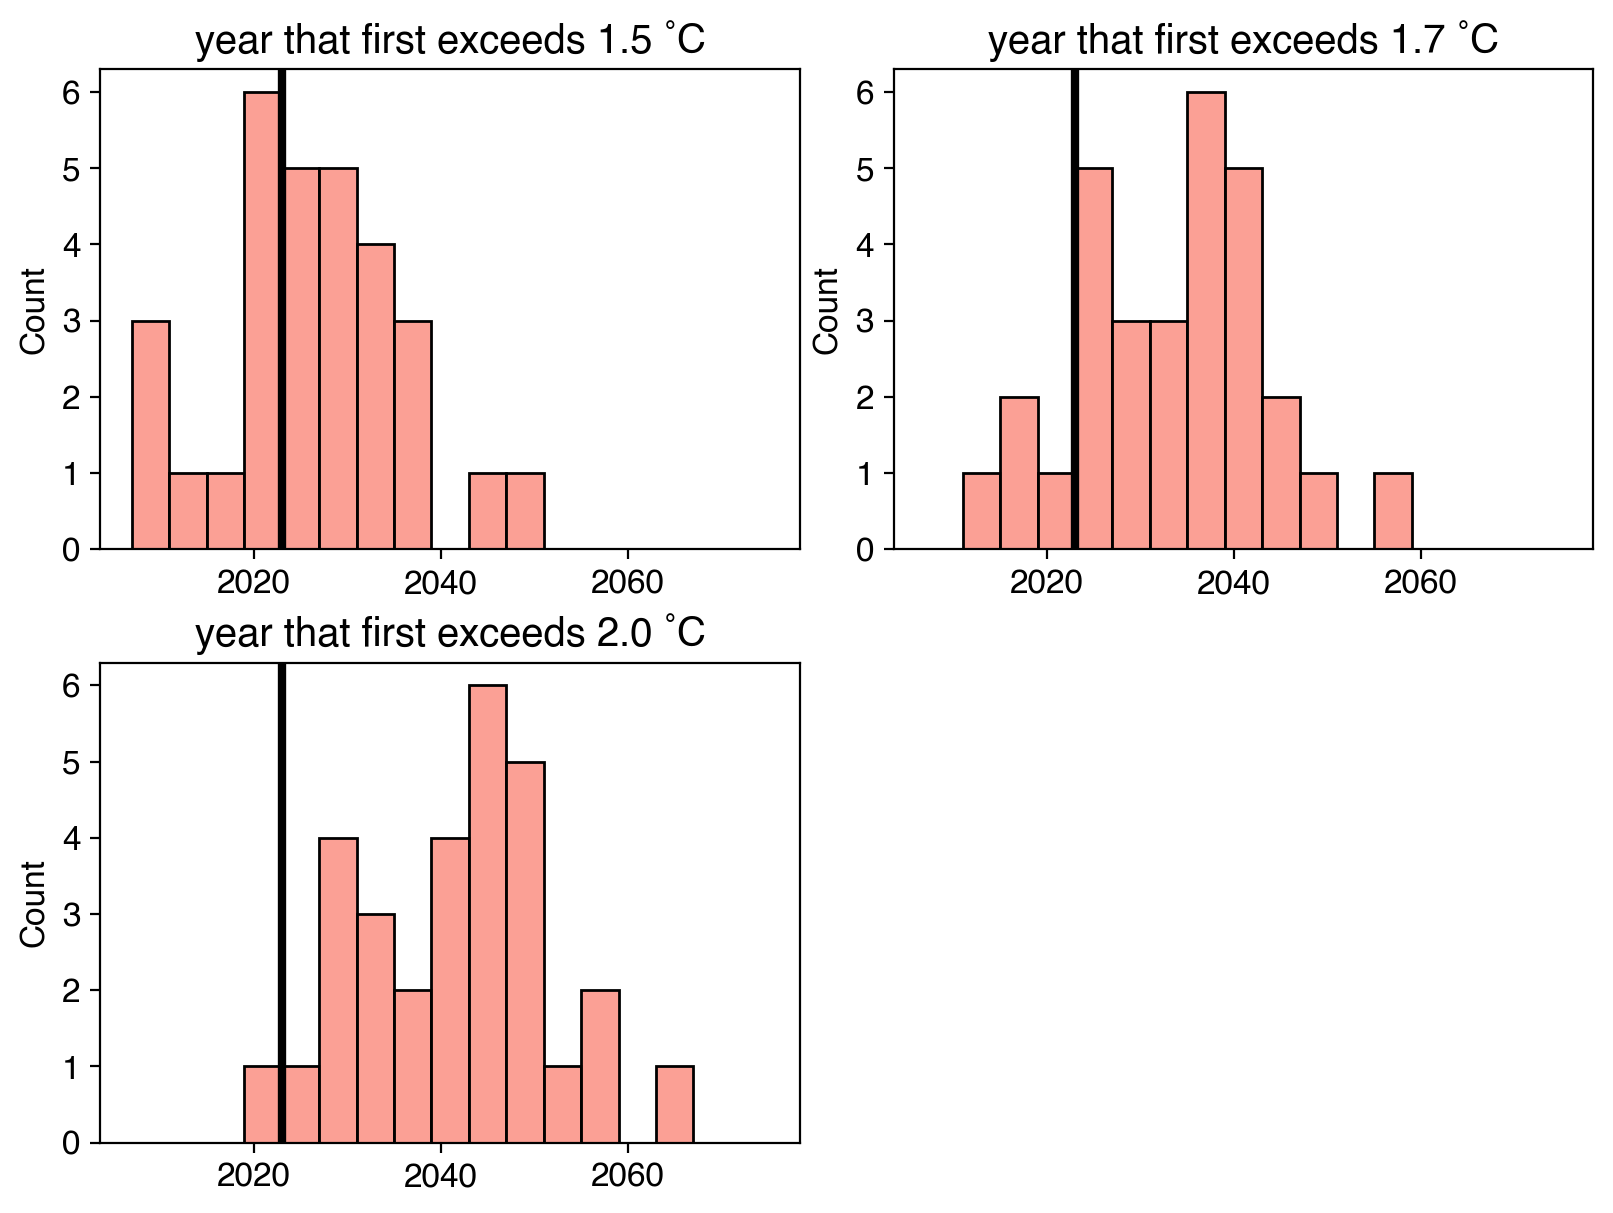

In [41]:
plt.figure(figsize = (8,6))
for iplot, thresh in enumerate(first_year.keys()):
    ax = plt.subplot(2,2,iplot + 1)
    bins = np.arange(2007.001, 2007.01 + 68, 4)
    sb.histplot(first_year[thresh], ax = ax, bins = bins, color='salmon')
    ax.set_title('year that first exceeds ' + str(thresh) + ' ˚C')
    plt.axvline(2023, color='k', linewidth=3)
plt.tight_layout(pad = .4)
dir = 'final_figures/supp/'
plt.savefig(dir + 'S_raw_climate_model_predictions.png', dpi=300)
plt.show()

In [44]:
## Now plot a likelihood of exceedance
threshes = dict()
likelihoods = dict()
windows = [1,5,10]
for window in windows:
    threshes[window] = []
    likelihoods[window] = []
    for thresh in first_year:
        threshes[window].append(thresh)
        likelihoods[window].append(sum(first_year[thresh] < 2024 + window)/ len(first_year[thresh] ))

In [45]:
likelihoods

{1: [0.43333333333333335, 0.13333333333333333, 0.06666666666666667],
 5: [0.5666666666666667, 0.36666666666666664, 0.06666666666666667],
 10: [0.8, 0.43333333333333335, 0.26666666666666666]}